change Outline

### - Introduction

### - Language Features Analysis
1. Load profile dataset
2. Filter out languages used by small number of users
3. Add area column
4. Add internationality column
5. Add Daily Tweets
6. Add year of subscription column
7. Features Desciption
8. Data Exploration
9. Feature Distribution of Different Languages
10. Features Distribution of Different Cultures

### - Using Behavior Analysis
1. 80-20 rules
2. Daily and Weekly Rhythms of Twitter Activity
3. Following Preference Analysis

### - Culture Prediction
1. Supervised learning
2. Unsupervised learning

# Language Influence Social Network Patterns: A Case Study

## Outline - write new

...

## 1. Introduction - update

In this project, we would like to play with the language feature from the original dataset. There has always been a stereotype that western people are more active on social media than eastern people. To verify such trends, we propose to analyze the features’ distribution of different language users. We can decide a user's activeness from some features such as tweet counts, friend numbers etc. Moreover, we would like to learn if language clusters exist on Twitter. If so, we want to learn to what extent they are going to interact with different clusters. In order to do so, we would run the community algorithm provided by networkx modules and see if we can detect the clusters of different language groups. In the end, we could apply machine learning to see if we can predict the language of a user based on the features of his/her own Twitter profile and that of the follower-followee network.

### Basic setup

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
import networkx as nx
from networkx.algorithms import community
from datetime import datetime, timedelta

In [2]:
# Ignore SettingWithCopyWarning - Reference: https://www.dataquest.io/blog/settingwithcopywarning/
pd.set_option('mode.chained_assignment', None)

In [3]:
# Set up paths for data extraction
EGO_PROFILE_PATH = "../Data/EgoAlterProfiles.txt"
EGO_NETWORK_PATH = "../Data/EgoNetworks.txt"
EGO_TIMELINE_PATH = "../Data/EgoTimelines.txt"

In [4]:
# Set up paths for data extraction
EGO_PROFILE_PATH = "Data/EgoAlterProfiles.txt"
EGO_NETWORK_PATH = "Data/EgoNetworks.txt"
EGO_TIMELINE_PATH = "Data/EgoTimelines.txt"

## 2. Language Features Analysis

### 2.1. Filter the data
The `ego_alter_profiles` dataset contains ID, followers count, friends count, statuses count and language data for all the egos and alters.

In [5]:
# Load the user profiles as Dataframe
ego_alter_profiles = pd.read_csv(EGO_PROFILE_PATH, sep = '\t')
ego_alter_profiles.head(10)

ID  IsEgo  followers_count  friends_count  statuses_count  utc_offset lang  \
0   1   True             30.0             28             9.0         NaN   en   
1   2   True              2.0              8             7.0    -14400.0   en   
2   3   True              1.0              0             0.0         NaN   fr   
3   4   True              3.0              3            68.0         NaN   en   
4   5   True             65.0            118           748.0         NaN   fr   
5   6   True              0.0              0             0.0         NaN   en   
6   7   True             17.0             71          1034.0    -10800.0   pt   
7   8   True             13.0              9             7.0         NaN   en   
8   9   True             26.0             16             6.0    -10800.0   en   
9  10   True              0.0              0             0.0         NaN   en   

                       created_at  protected  
0  Wed Oct 26 03:30:32 +0000 2011      False  
1  Mon Jul 27 20:46:32 +0000 2009      False  
2  Mon Apr 23 20:57:26 +0000 2012      False  
3  Sun Feb 14 07:50:39 +0000 2010      False  
4  Mon Jun 11 14:17:06 +0000 2012      False  
5  Sun Mar 28 03:22:55 +0000 2010      False  
6  Thu Nov 11 22:05:15 +0000 2010       True  
7  Fri Sep 24 19:52:58 +0000 2010      False  
8  Sun Feb 14 10:49:28 +0000 2010      False  
9  Wed Nov 30 04:02:50 +0000 2011      False

#### 2.1.1. Filter out irrelevant users
We filter the dataset to include the data for public ego profiles with at least one follower and at least one friend, and have posted at least one tweet.

In [6]:
## Filter the dataset to include users with the following conditions:
# 1. Is an ego
ego_alter_profiles = ego_alter_profiles[ego_alter_profiles['IsEgo']==True]
# 2. Has a public profile
ego_alter_profiles = ego_alter_profiles[ ego_alter_profiles['protected']==False ]
# 3. Has at least one follower and at least one friend
ego_alter_profiles = ego_alter_profiles[ego_alter_profiles['followers_count']>0]
ego_alter_profiles = ego_alter_profiles[ego_alter_profiles['friends_count']>0]
# 4. Posted at least one tweet
ego_alter_profiles = ego_alter_profiles[ ego_alter_profiles['statuses_count']>0 ]

#### 2.1.2. Filter out the 'small languages'
Some languages in our dataset are used by a very small number of users (chosen limit: 100 users). Including such users might bias the results. Hence, these lanuages are not taken into account and filtered out. 

In [7]:
# Find the list of egos
egos = ego_alter_profiles['ID']
# Find the count for each language
ego_alter_profiles['lang'] = ego_alter_profiles['lang'].str.lower()
languages_count = ego_alter_profiles.groupby('lang')['ID'].count().reset_index(name = 'count')
# Find the list of languages used by very less users
small_language = languages_count[languages_count['count'] < 100]['lang'].to_list()
# Create a new Dataframe and filter out the 'small language' users
languages = ego_alter_profiles[ ~ego_alter_profiles['lang'].isin(small_language) ].reset_index(drop = True)
languages = languages[['ID','IsEgo', 'followers_count', 'friends_count', 'statuses_count', 'lang', 'created_at']]
languages = languages.dropna()

### 2.2. Calculate additional data
More information about the users can be extracted using the available data in order to make the data analysis more intuitive.

#### 2.2.1. Broad communities: eastern vs western languages
Since we are interested in the analysis between the eastern and western communities and their behaviours on Twitter, we classify the languages into two broad areas, namely `East` and `West`. The classification is based on the geographical locations where the language is spoken.

The `language_code.txt` file contains the list of languages in our dataset along with the description of the language codes used in the `lang` column.

In [8]:
# Create lists of the 'eastern' and 'western' languages from the ego_alter_profiles
eastern_language = ['ar', 'az', 'fil', 'id', 'in', 'ja', 'ko', 'ms', 'msa', 'th', 'tr', 'vi' , 'zh', 'zh-cn',
                    'zh-hans', 'zh-hant', 'zh-tw']
western_language = ['bg', 'ca', 'cs', 'da', 'de', 'el', 'en', 'en-au', 'en-gb', 'es', 'es-mx', 'eu', 'fa',
                 'fi',  'fr', 'he', 'hi', 'hr', 'hu',   'it', 'ka', 'lv', 'nb', 'nl', 'no', 'pl', 'pt',
                 'pt-pt', 'ro', 'ru', 'sr', 'sv', 'uk']

In [9]:
# Function to sort users into 'West' and 'East' categories
def classify_lang(lang):
    if lang in western_language:
        return 'West'
    if lang in eastern_language:
        return 'East'

# Add a new column 'area' to classify users into western and eastern areas
languages['area'] = languages['lang'].apply(classify_lang)

#### 2.2.2. Internationality based on languages of followers
The followers of each user are characterised based on the language they use. It is highly likely that the followers use the same language as the user they follow. But a user may also have a more diverse group of followers who use other languages. In order to study this propery, we create a new `internationality` column which is defined as: (number of followers who use a language different than the user) divided by (total number of the user's followers). 

In [10]:
# Load the ego networks as DataFrame
ego_networks = pd.read_csv(EGO_NETWORK_PATH, sep = '\t')

# Load the user profiles as Dataframe with only the language information
all_languages = pd.read_csv(EGO_PROFILE_PATH, sep = '\t')[['ID','lang']]
all_languages['lang'] = all_languages['lang'].str.lower()

**Method:** We filter the ego networks Dataframe to only contain the followers with the same language as the user (i.e. followee). Later, we calculate the `internationality` using an inverse logic (different language followers = total followers - same language followers).

In [11]:
# Filter the ego networks to have only ego followees
ego_networks = ego_networks[ego_networks['followeeID'].isin(egos)]

# Create dictionary mapping between users and their languages 
user_lang = dict(zip(all_languages['ID'], all_languages['lang']))

# Function to return user language from ID
def get_lang(ID):
    return user_lang[ID]

# Add each followers language
ego_networks['followers_lang'] = ego_networks['followerID'].apply(get_lang)

# Filter the ego network to keep only the followers with the same language as the user
ego_networks = ego_networks[ ego_networks['followeeID'].apply(get_lang)==ego_networks['followers_lang'] ]

In [12]:
# Compute number of the same language relations for each user
same_lang_count = ego_networks.groupby(['followeeID', 'followers_lang'], as_index=False).size().to_frame('Internationality')

# Add 'internationality' column to the languages Dataframe 
languages = languages.merge(same_lang_count, how='left', left_on='ID', right_on='followeeID').fillna(0)
languages['Internationality'] = 1-languages['Internationality']/languages['followers_count']

languages.head()

ID  IsEgo  followers_count  friends_count  statuses_count lang  \
0   1   True             30.0             28             9.0   en   
1   2   True              2.0              8             7.0   en   
2   4   True              3.0              3            68.0   en   
3   5   True             65.0            118           748.0   fr   
4   8   True             13.0              9             7.0   en   

                       created_at  area  Internationality  
0  Wed Oct 26 03:30:32 +0000 2011  West          0.033333  
1  Mon Jul 27 20:46:32 +0000 2009  West          0.500000  
2  Sun Feb 14 07:50:39 +0000 2010  West          0.000000  
3  Mon Jun 11 14:17:06 +0000 2012  West          0.123077  
4  Fri Sep 24 19:52:58 +0000 2010  West          0.846154

#### 2.2.3. Average daily number of tweets
In order to characterize 'activeness' of a user on a daily basis, the average daily number of tweets is calculated by dividing the total number of tweets by the number of active days for each user. The number of active days is defined as the number of days starting from the creation of the user's Twitter account to the most recent record of a Tweet in the dataset. 

In [13]:
# Load the ego timelines as Dataframe
timelines = pd.read_csv(EGO_TIMELINE_PATH, sep = '\t', encoding = 'latin - 1')

In [14]:
# Convert the user subscription time to datetime object
def convert_time_format(twt_time: str):
    std_time = datetime.strptime(twt_time, '%a %b %d %H:%M:%S %z %Y')
    return std_time

# Add the standard datetime format to a new column - timelines dataframe
timelines['std_time'] = timelines['created_at'].astype('str').apply(convert_time_format)

# Add the standard datetime format to a new column - languages dataframe
languages['std_time'] = languages['created_at'].astype('str').apply(convert_time_format)

In [15]:
# Find the date for the most recent tweet
recent_date = timelines['std_time'].max()

# Find the number of days between the user subscription time and the most recent tweet available
languages['num_days'] = recent_date - languages['std_time']

# Function to return number of days from the timedelta object
def get_days(time_obj):
    return time_obj.days

# Get the number of days from the timedelta object for each user
languages['num_days'] = languages['num_days'].apply(get_days)

In [16]:
# Find mean number of tweets per day 
languages['avg_daily_tweets'] = languages['statuses_count'] / languages['num_days']

languages.head()

ID  IsEgo  followers_count  friends_count  statuses_count lang  \
0   1   True             30.0             28             9.0   en   
1   2   True              2.0              8             7.0   en   
2   4   True              3.0              3            68.0   en   
3   5   True             65.0            118           748.0   fr   
4   8   True             13.0              9             7.0   en   

                       created_at  area  Internationality  \
0  Wed Oct 26 03:30:32 +0000 2011  West          0.033333   
1  Mon Jul 27 20:46:32 +0000 2009  West          0.500000   
2  Sun Feb 14 07:50:39 +0000 2010  West          0.000000   
3  Mon Jun 11 14:17:06 +0000 2012  West          0.123077   
4  Fri Sep 24 19:52:58 +0000 2010  West          0.846154   

                   std_time  num_days  avg_daily_tweets  
0 2011-10-26 03:30:32+00:00      1101          0.008174  
1 2009-07-27 20:46:32+00:00      1921          0.003644  
2 2010-02-14 07:50:39+00:00      1719          0.039558  
3 2012-06-11 14:17:06+00:00       871          0.858783  
4 2010-09-24 19:52:58+00:00      1497          0.004676

#### 2.2.4. Lateness of subscription
In addition to the daily 'activeness' of each user, we characterise a user's long-term involvement with Twitter by their subscription years, `year`. It denotes how late a user joined Twitter in reference to the first recorded subscription in our dataset. It is calculated as a difference in the number of years of subscription between each user and the first subscription.

This column is also used later in order to normalize the dataset for more uniform and improved plots. 

In [17]:
# Function to return years from a timedelta object
def get_years(time_obj):
    return time_obj.year

# Add subscription_year column
languages['year'] = languages['std_time'].apply(get_years)
languages['year'] -= min(languages['year'])

# Dropping the irrelevant columns
languages = languages.drop(columns = ['created_at', 'std_time', 'num_days'])

languages.head()

ID  IsEgo  followers_count  friends_count  statuses_count lang  area  \
0   1   True             30.0             28             9.0   en  West   
1   2   True              2.0              8             7.0   en  West   
2   4   True              3.0              3            68.0   en  West   
3   5   True             65.0            118           748.0   fr  West   
4   8   True             13.0              9             7.0   en  West   

   Internationality  avg_daily_tweets  year  
0          0.033333          0.008174     5  
1          0.500000          0.003644     3  
2          0.000000          0.039558     4  
3          0.123077          0.858783     6  
4          0.846154          0.004676     4

### 2.3. Features Description

To get an overview of the dataset, we grouped the dataset by the language column and calculated the mean values for the followers count, friends count, statuses count and average daily statuses count. This gives a better statistical understanding among different languages users. 

In [18]:
# Create a new Dataframe and group the users by languages by calculating the mean
languages_stat = (languages.groupby('lang')[['followers_count', 'friends_count', 'statuses_count', 'avg_daily_tweets','Internationality','year']]
.mean()
.reset_index())

# Create a dictionary mapping between the languages and their count
languages_count_dict = dict(zip(languages_count['lang'], languages_count['count']))

# Function to return the language count
def get_count(lang):
    return languages_count_dict[lang]

# Add a column for the number of users for each language
languages_stat['user_count'] = languages_stat['lang'].apply(get_count)
# Add a column for the broad 'area' of the language into West or East
languages_stat['area'] = languages_stat['lang'].apply(classify_lang)

# Sort the Dataframe in an ascending order of the langauge's user count
languages_stat.set_index('lang', inplace = True)
languages_stat.sort_values(by = 'user_count', inplace = True)

languages_stat.head()

followers_count  friends_count  statuses_count  avg_daily_tweets  \
lang                                                                     
de         146.175926     207.916667      246.185185          0.273173   
ko          37.046512      77.542636      344.527132          0.781984   
it          46.696429      98.238095      387.238095          0.505665   
ru         126.563025     204.126050      392.865546          0.976516   
fr          67.009646     105.009646      602.504823          1.188414   

      Internationality      year  user_count  area  
lang                                                
de            0.494275  6.166667         108  West  
ko            0.239502  6.162791         129  East  
it            0.267943  6.273810         168  West  
ru            0.254950  6.617647         238  West  
fr            0.329503  6.337621         311  West

In [19]:
## NOTE TO US: CONTINUE CLEANING...

### 8. Data Exploration

From the figures below, we can figure out the language composition of the dataset.

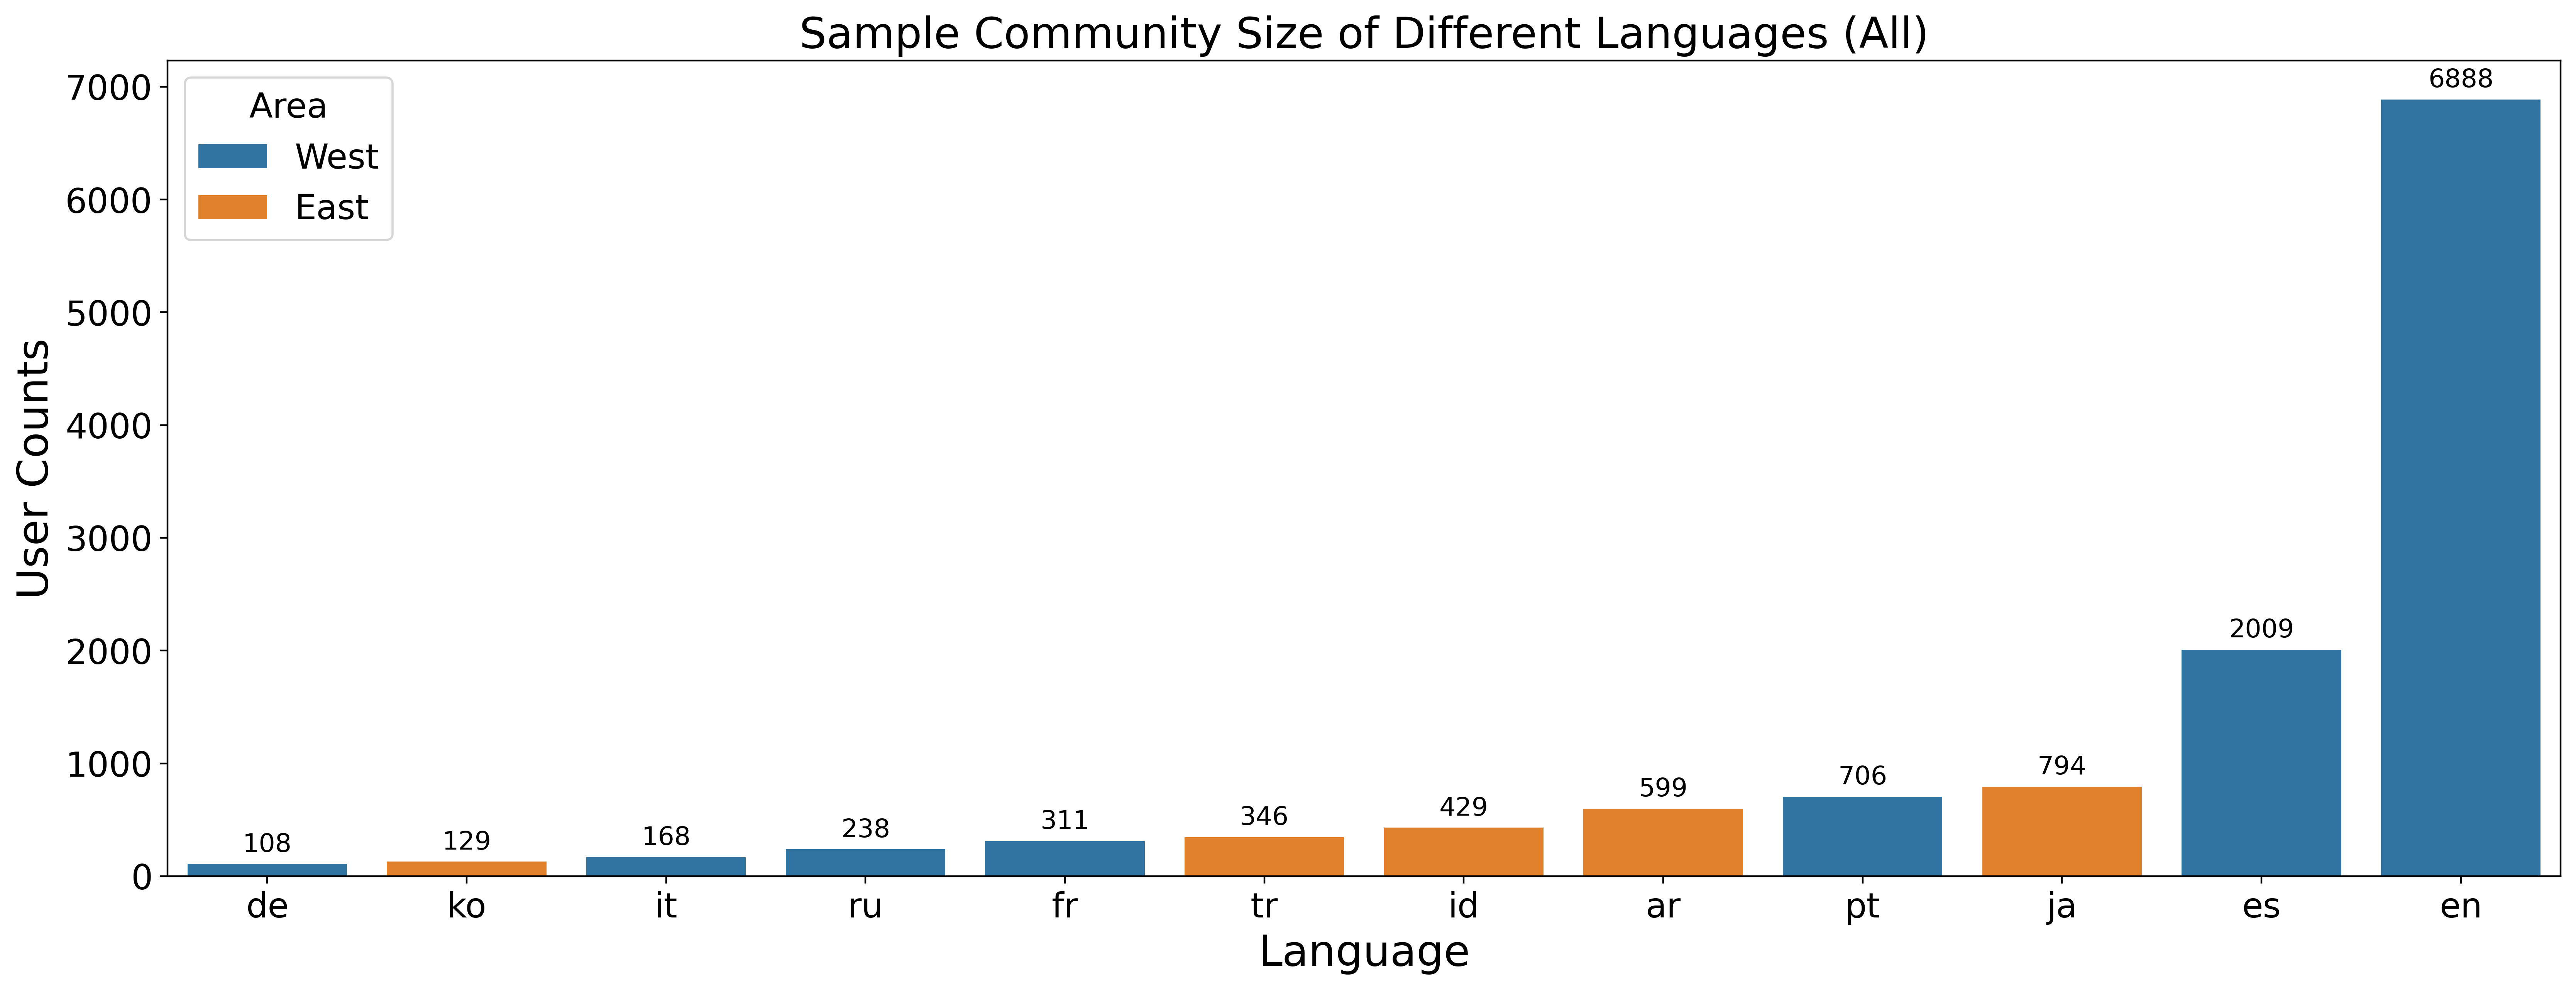

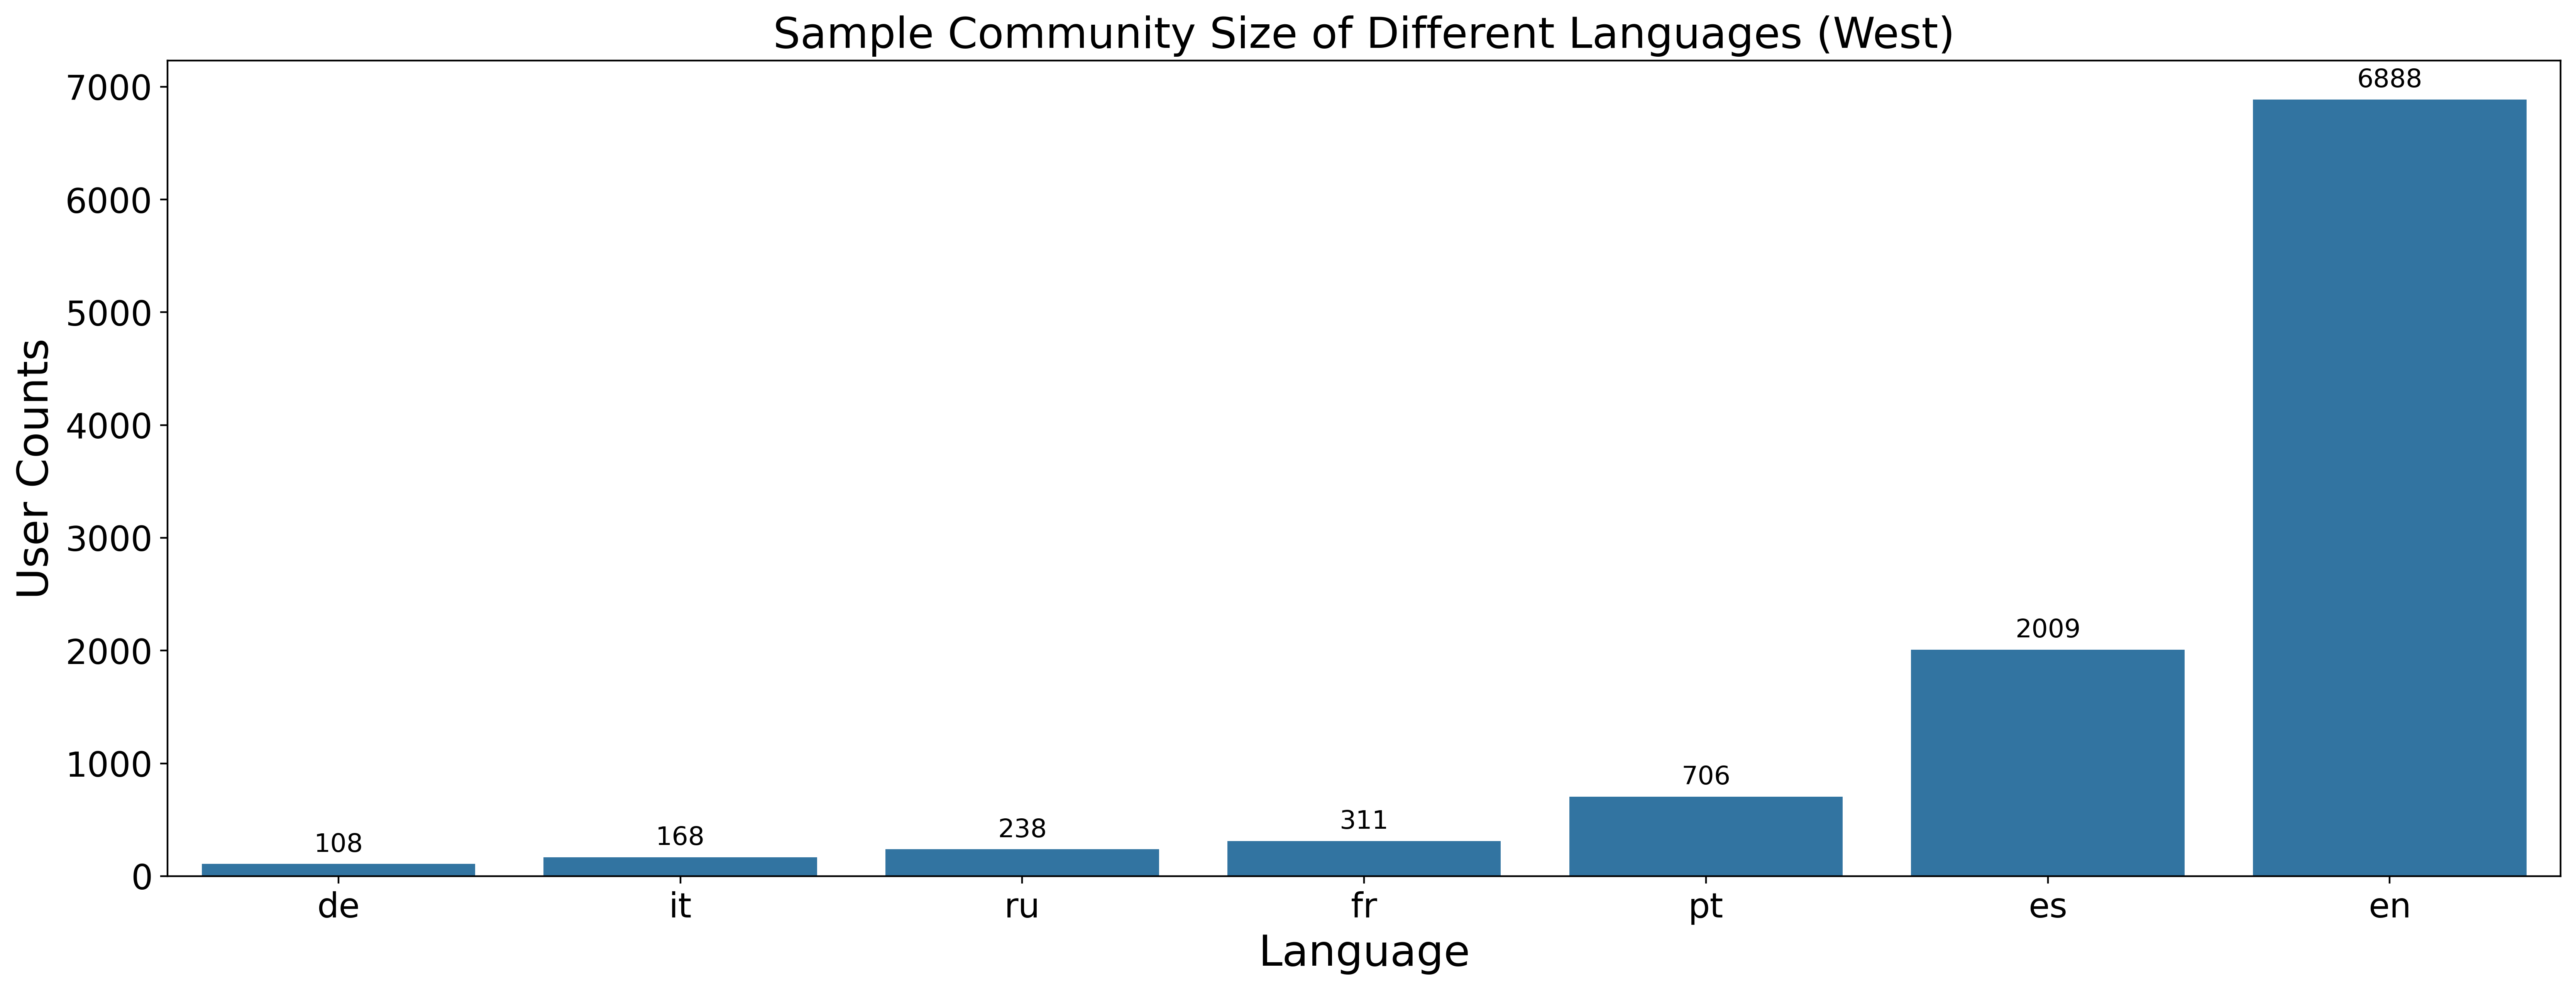

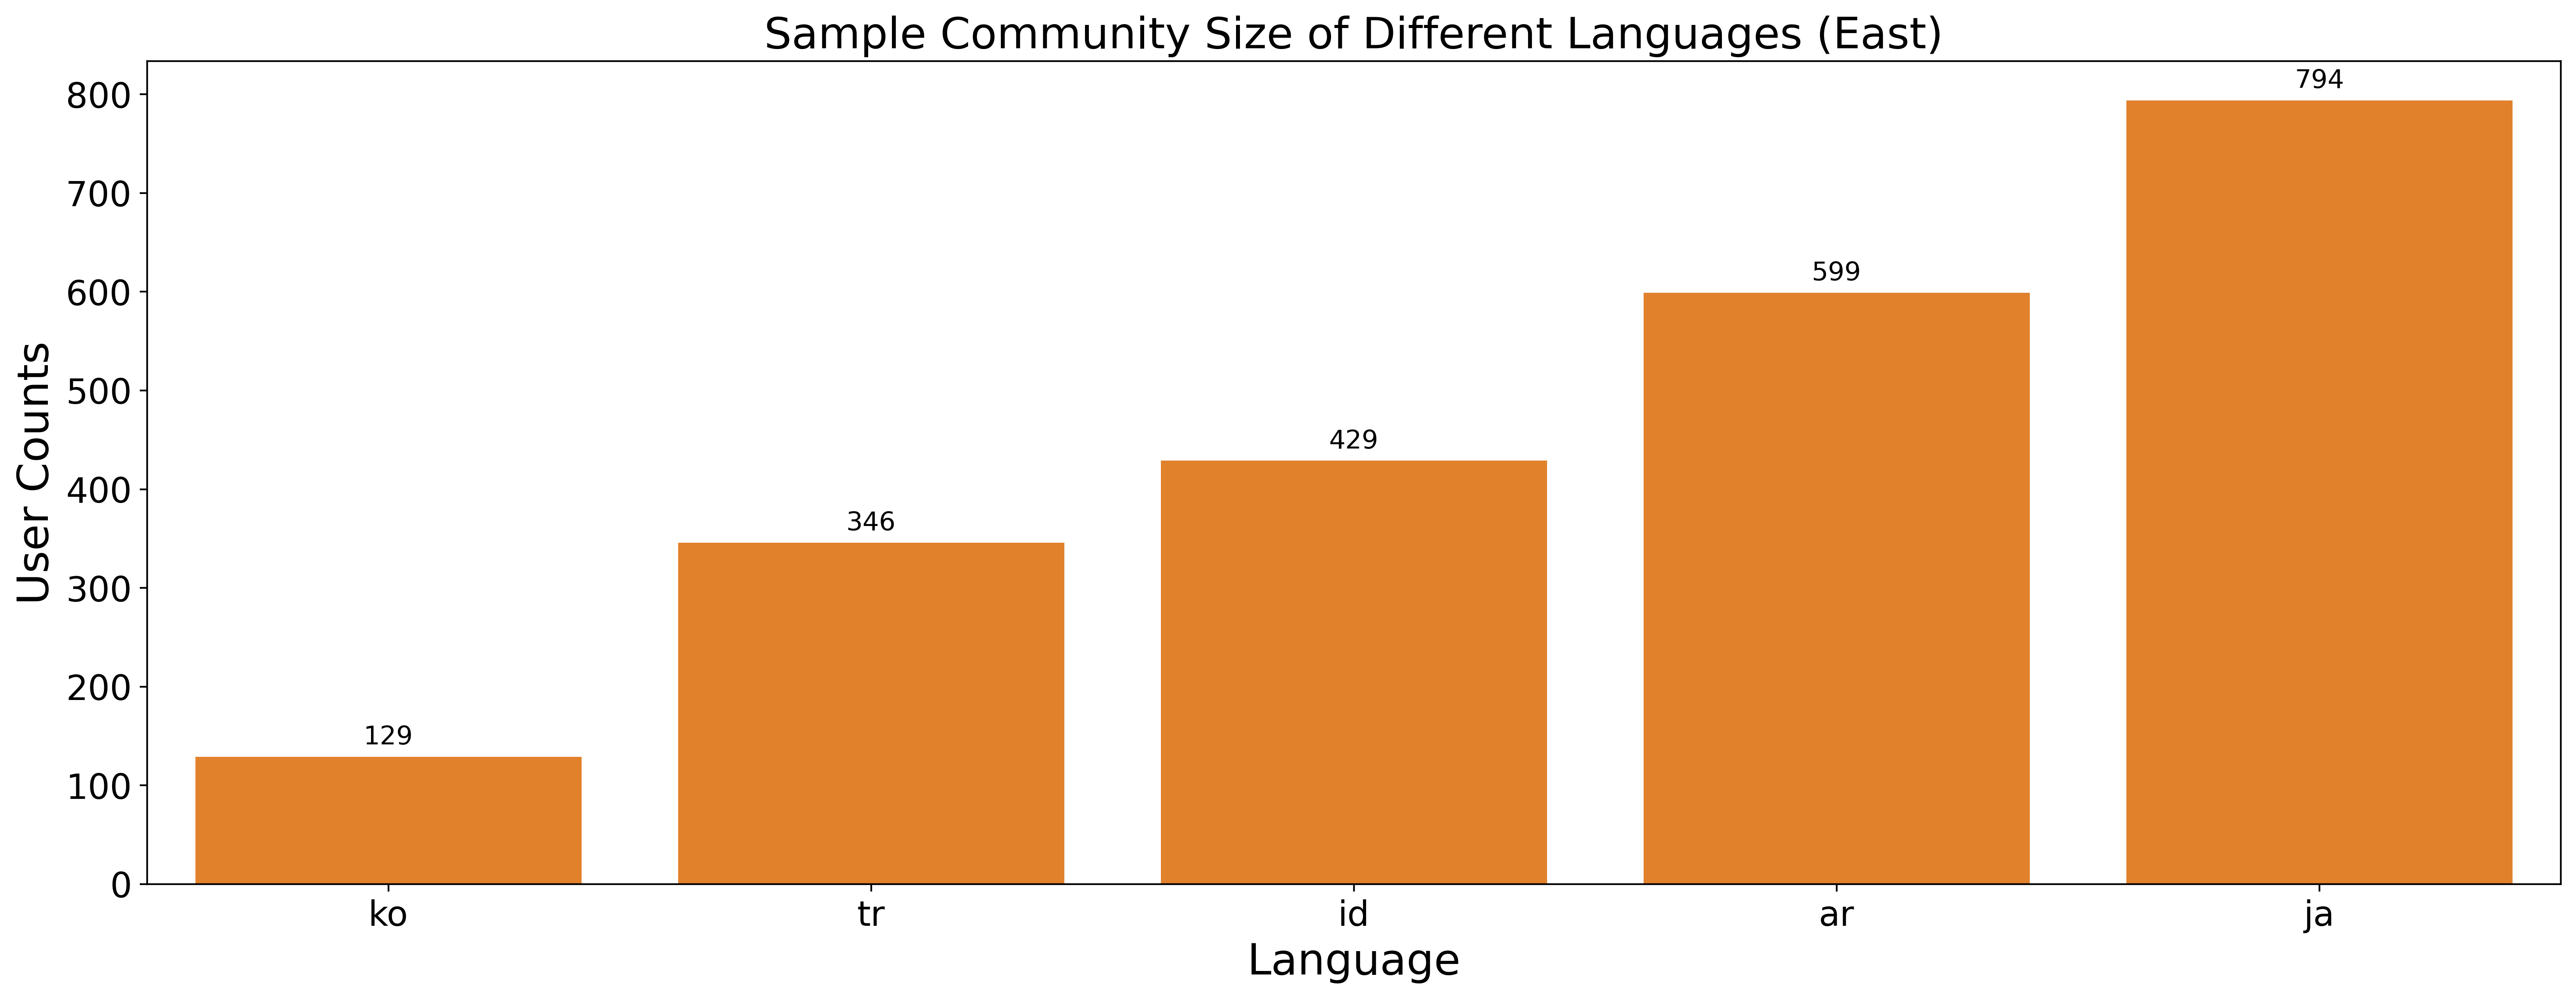

In [20]:
fig, ax = plt.subplots(figsize = (20, 7), dpi = 400)

#ax.set(yscale = 'log')
splot = sns.barplot(x = languages_stat.index, y = languages_stat['user_count'], hue = languages_stat['area'], ax = ax,
           dodge = False)
ax.set_xlabel('Language', fontsize = 20)
ax.set_ylabel('User Counts', fontsize = 20)
ax.set_title('Sample Community Size of Different Languages (All)', fontsize=20)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
plt.legend(title="Area", fontsize=16, title_fontsize=16)

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points',
                   fontsize = 12) 
#plt.savefig('img/community_size_all.jpg')

fig, ax = plt.subplots(figsize = (20, 7), dpi = 400)

languages_stat_west = languages_stat[languages_stat['area']=='West']

#ax.set(yscale = 'log')
splot = sns.barplot(x = languages_stat_west.index, y = languages_stat_west['user_count'], 
            color = sns.color_palette()[0], ax = ax, dodge = False)
ax.set_xlabel('Language', fontsize = 20)
ax.set_ylabel('User Counts', fontsize = 20)
ax.set_title('Sample Community Size of Different Languages (West)', fontsize=20)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points',
                   fontsize = 12) 

#plt.savefig('img/community_size_west.jpg')

fig, ax = plt.subplots(figsize = (20, 7), dpi = 400)

languages_stat_east = languages_stat[languages_stat['area']=='East']

#ax.set(yscale = 'log')
splot = sns.barplot(x = languages_stat_east.index, y = languages_stat_east['user_count'], 
            color = sns.color_palette()[1], ax = ax, dodge = False)
ax.set_xlabel('Language', fontsize = 20)
ax.set_ylabel('User Counts', fontsize = 20)
ax.set_title('Sample Community Size of Different Languages (East)', fontsize=20)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points',
                   fontsize = 12,) 


#plt.savefig('img/community_size_east.jpg')

Conclusions, if any: 
1. Beware of log scale. Very high majority of < en > language users.
2. Top three western languages < en, es, pt > constitute ~75% of the total users. 
3. 9 western vs 5 eastern languages. 15,290 western vs 3,247 eastern users.

### 9. Feature Distribution of Different Languages

From the figures below, we can understand the distribution of the features of different languages.

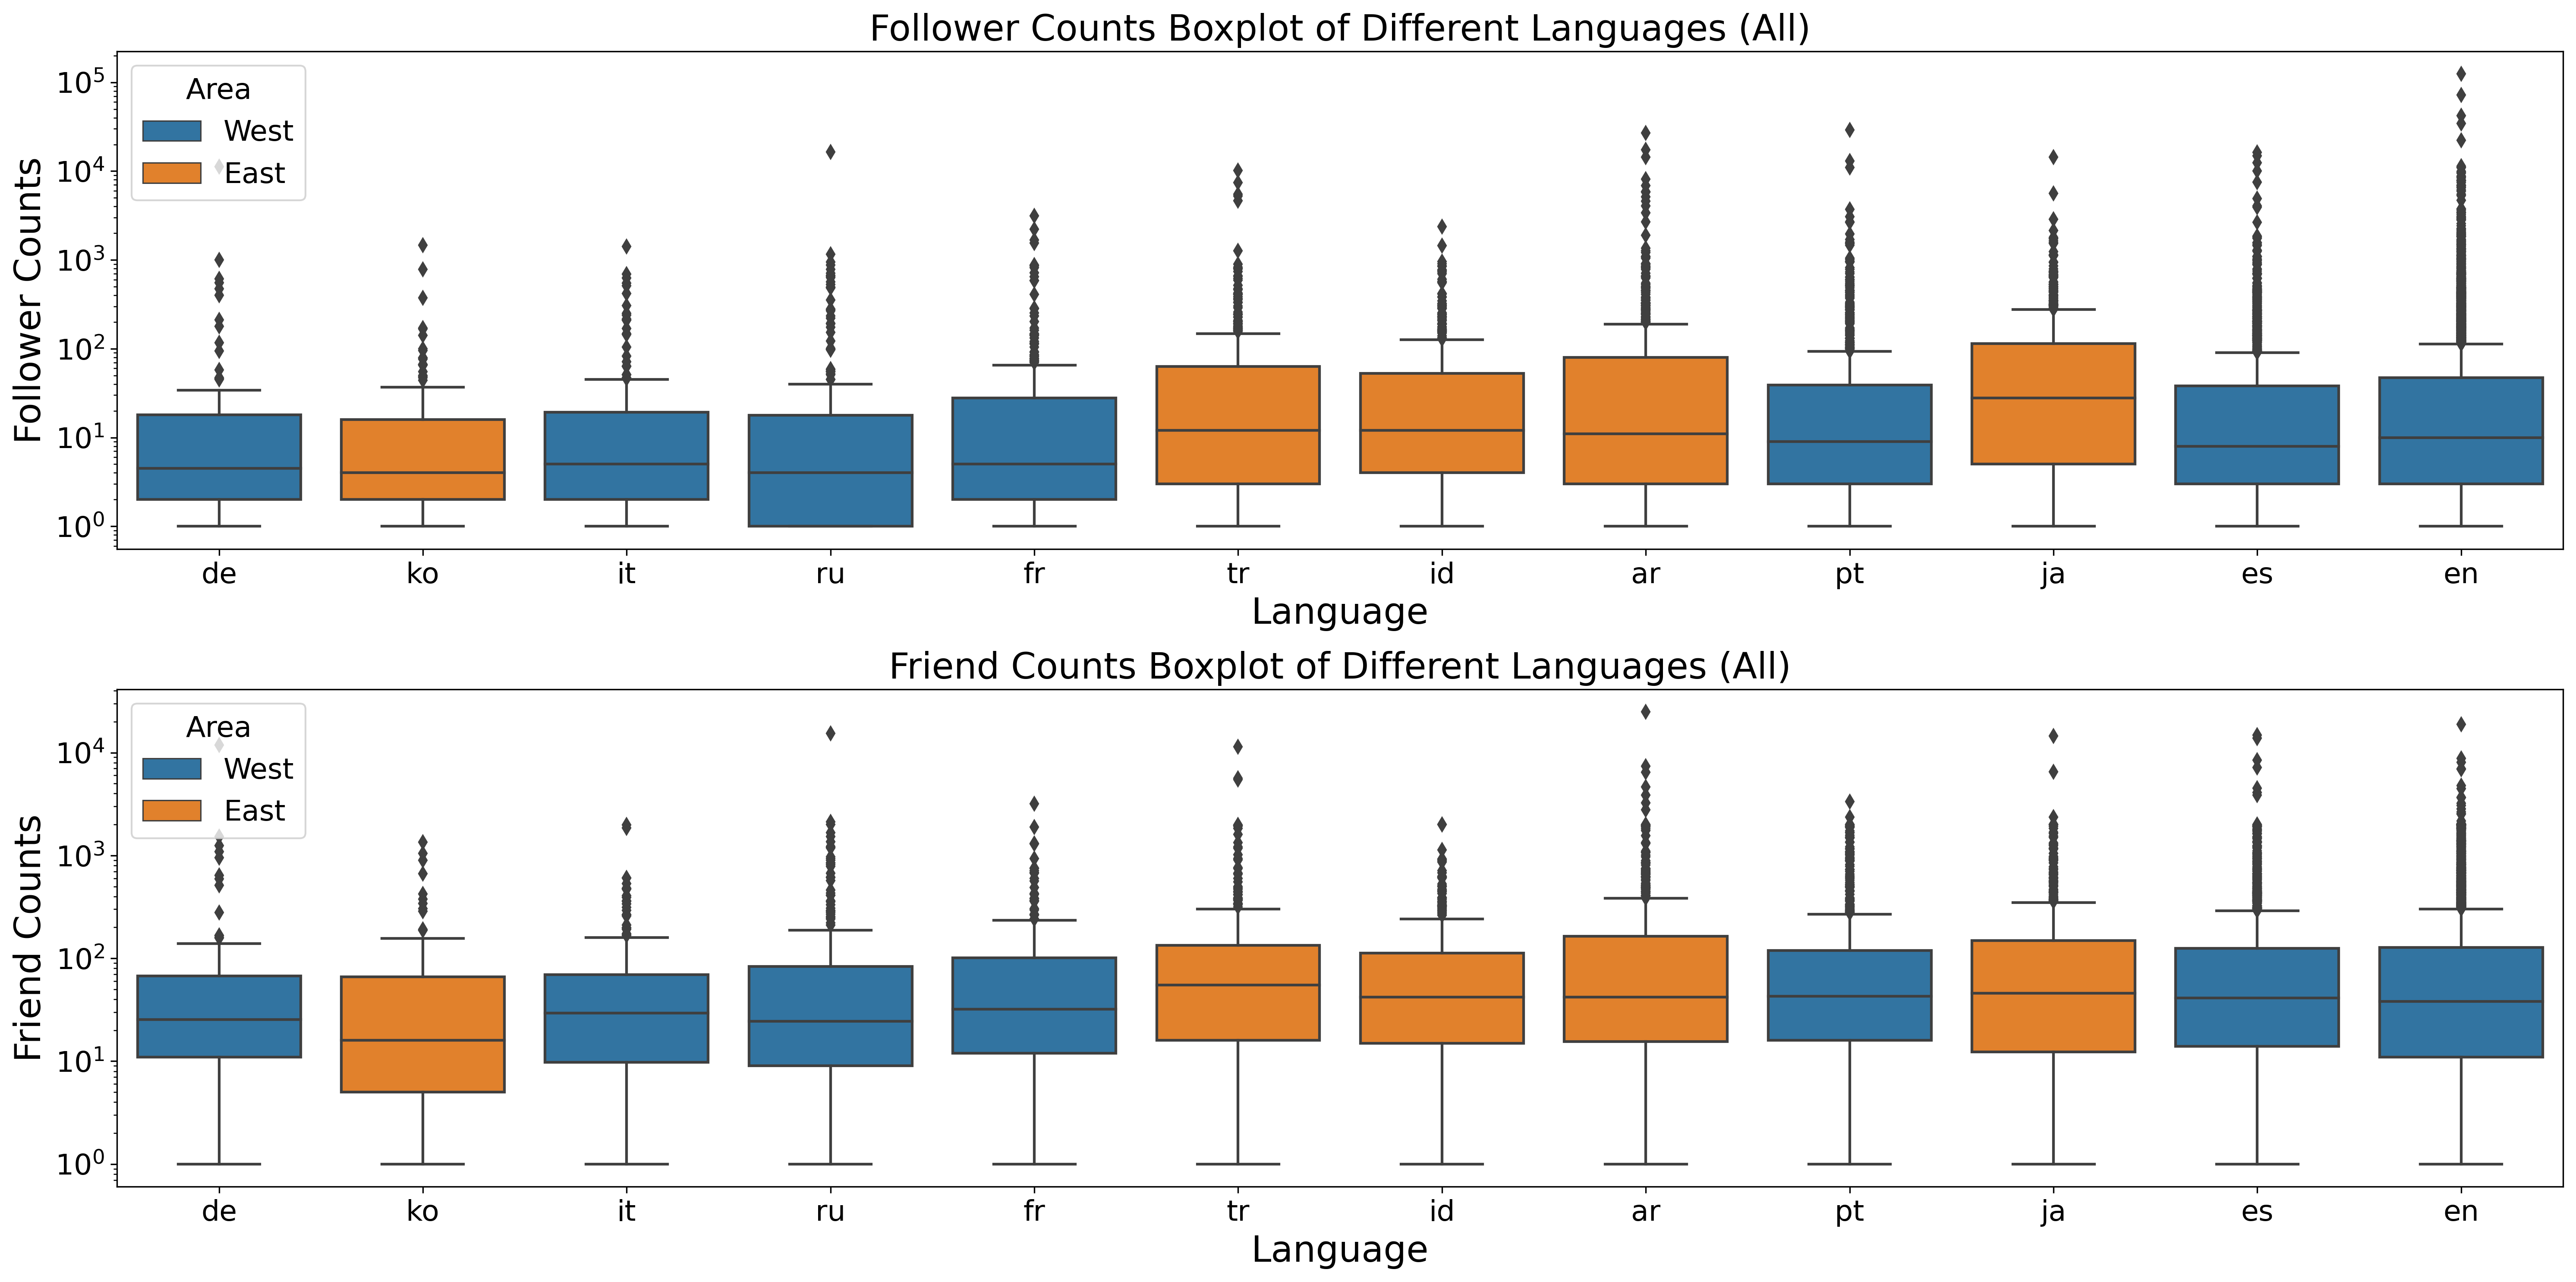

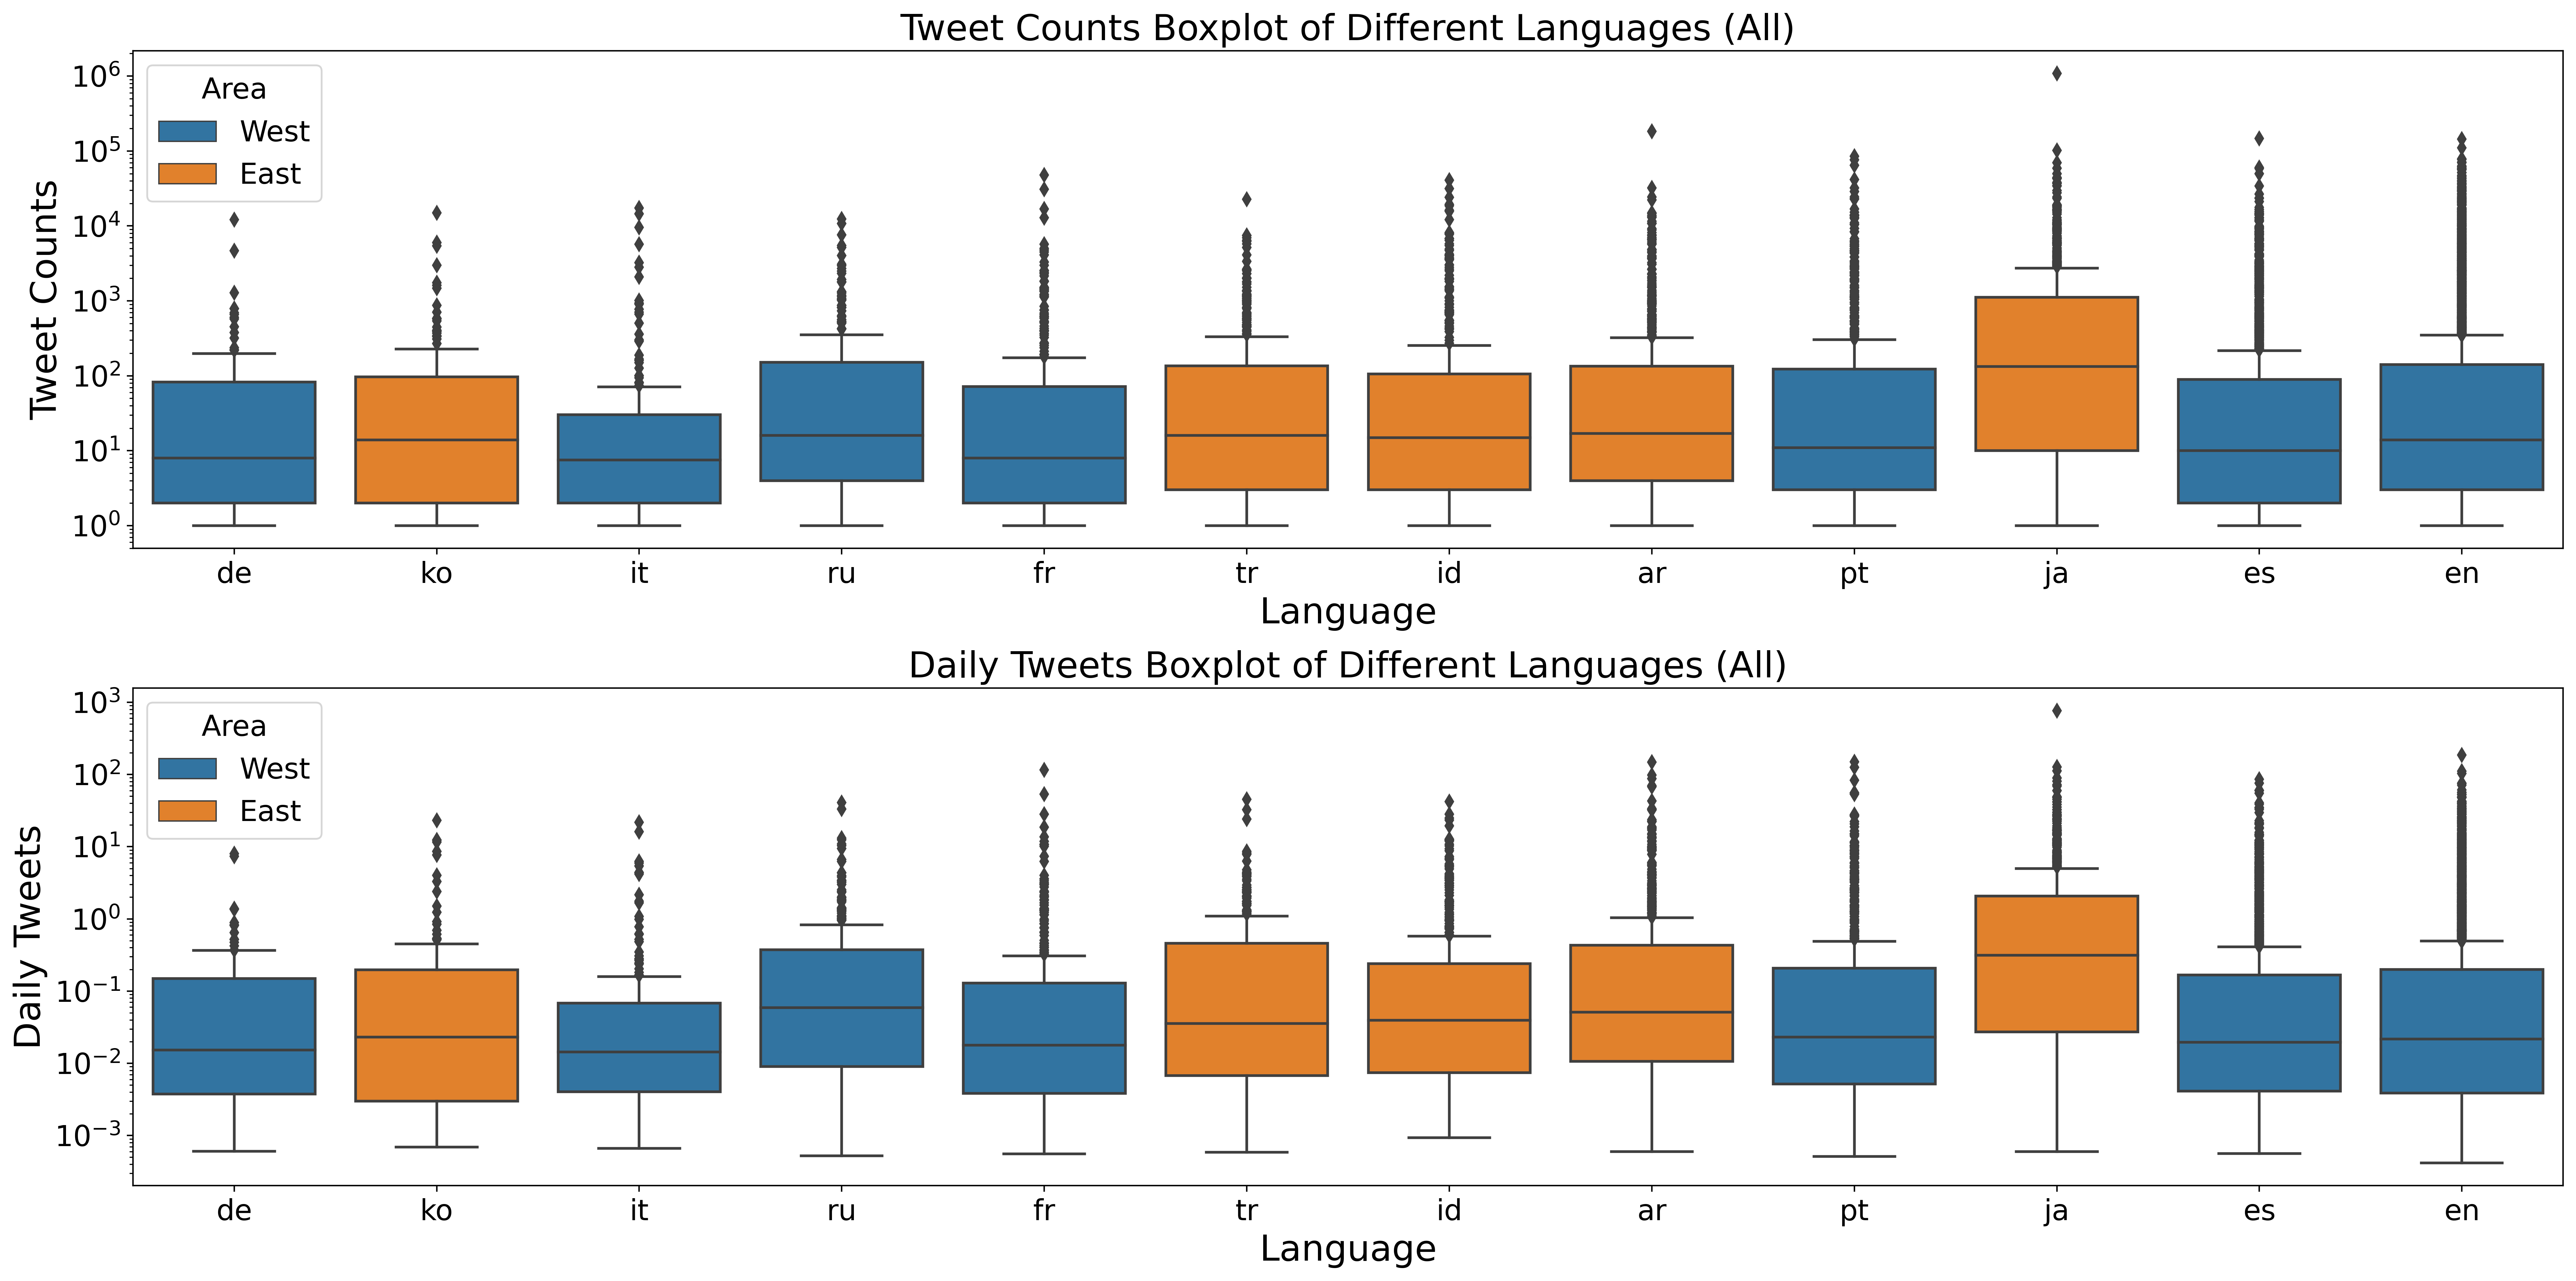

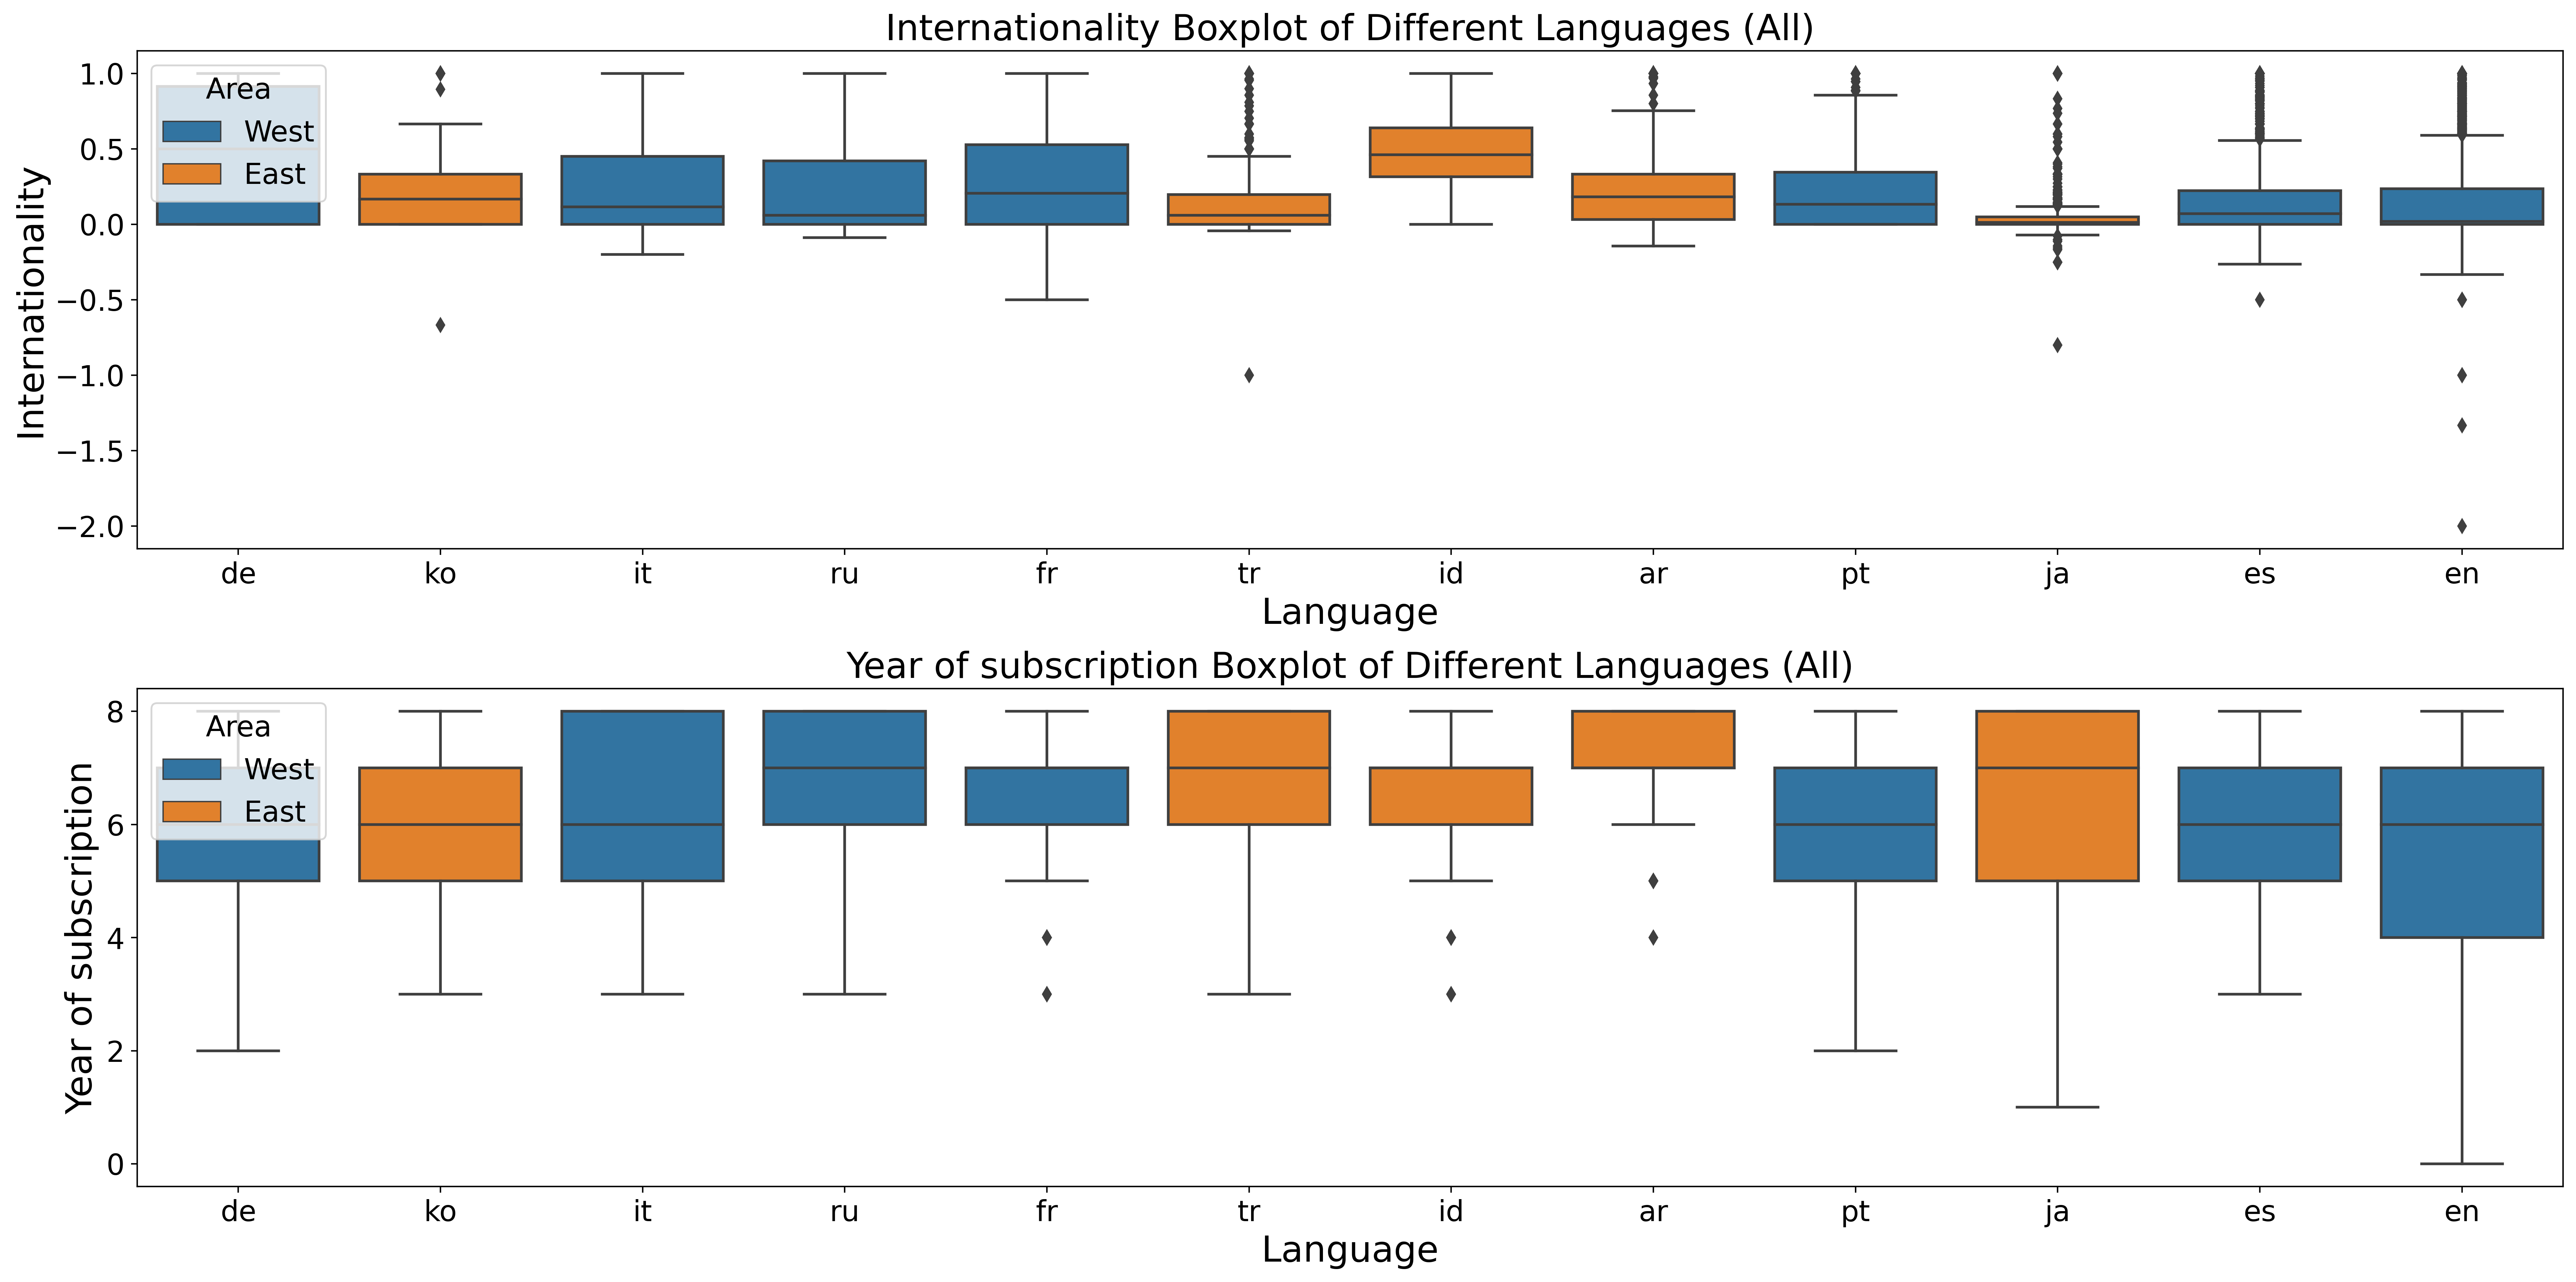

In [21]:
language_order = languages_stat.index.tolist()

# popularity

fig, ax = plt.subplots(2, 1, figsize = (20, 10), dpi = 300)

ax[0].set(yscale="log")
sns.boxplot(x = 'lang', y = 'followers_count', data = languages, order = language_order, ax = ax[0],
           hue = 'area', dodge = False)
ax[0].set_xlabel('Language', fontsize = 20)
ax[0].set_ylabel('Follower Counts', fontsize = 20)
ax[0].set_title('Follower Counts Boxplot of Different Languages (All)', fontsize=20)
ax[0].xaxis.set_tick_params(labelsize=16)
ax[0].yaxis.set_tick_params(labelsize=16)
ax[0].legend(title="Area", fontsize=16, title_fontsize=16, loc = 2)

ax[1].set(yscale="log")
sns.boxplot(x = 'lang', y = 'friends_count', data = languages, order = language_order, ax = ax[1],
           hue = 'area', dodge = False)
ax[1].set_xlabel('Language', fontsize = 20)
ax[1].set_ylabel('Friend Counts', fontsize = 20)
ax[1].set_title('Friend Counts Boxplot of Different Languages (All)', fontsize=20)
ax[1].xaxis.set_tick_params(labelsize=16)
ax[1].yaxis.set_tick_params(labelsize=16)
ax[1].legend(title="Area", fontsize=16, title_fontsize=16, loc = 2)

fig.tight_layout()
#plt.savefig("img/popularity_statistics_boxplot.jpg")

# activness

fig, ax = plt.subplots(2, 1, figsize = (20, 10), dpi = 400)

ax[0].set(yscale="log")
sns.boxplot(x = 'lang', y = 'statuses_count', data = languages, order = language_order, ax = ax[0],
           hue = 'area', dodge = False)
ax[0].set_xlabel('Language', fontsize = 20)
ax[0].set_ylabel('Tweet Counts', fontsize = 20)
ax[0].set_title('Tweet Counts Boxplot of Different Languages (All)', fontsize=20)
ax[0].xaxis.set_tick_params(labelsize=16)
ax[0].yaxis.set_tick_params(labelsize=16)
ax[0].legend(title="Area", fontsize=16, title_fontsize=16, loc = 2)

ax[1].set(yscale="log")
sns.boxplot(x = 'lang', y = 'avg_daily_tweets', data = languages, order = language_order, ax = ax[1],
           hue = 'area', dodge = False)
ax[1].set_xlabel('Language', fontsize = 20)
ax[1].set_ylabel('Daily Tweets', fontsize = 20)
ax[1].set_title('Daily Tweets Boxplot of Different Languages (All)', fontsize=20)
ax[1].xaxis.set_tick_params(labelsize=16)
ax[1].yaxis.set_tick_params(labelsize=16)
ax[1].legend(title="Area", fontsize=16, title_fontsize=16, loc = 2)

fig.tight_layout()
#plt.savefig("img/activeness_statistics_boxplot.jpg")

fig, ax = plt.subplots(2, 1, figsize = (20, 10), dpi = 400)

#ax[0].set(yscale="log")
sns.boxplot(x = 'lang', y = 'Internationality', data = languages, order = language_order, ax = ax[0],
           hue = 'area', dodge = False)
ax[0].set_xlabel('Language', fontsize = 20)
ax[0].set_ylabel('Internationality', fontsize = 20)
ax[0].set_title('Internationality Boxplot of Different Languages (All)', fontsize=20)
ax[0].xaxis.set_tick_params(labelsize=16)
ax[0].yaxis.set_tick_params(labelsize=16)
ax[0].legend(title="Area", fontsize=16, title_fontsize=16, loc = 2)

#ax[1].set(yscale="log")
sns.boxplot(x = 'lang', y = 'year', data = languages, order = language_order, ax = ax[1],
           hue = 'area', dodge = False)
ax[1].set_xlabel('Language', fontsize = 20)
ax[1].set_ylabel('Year of subscription', fontsize = 20)
ax[1].set_title('Year of subscription Boxplot of Different Languages (All)', fontsize=20)
ax[1].xaxis.set_tick_params(labelsize=16)
ax[1].yaxis.set_tick_params(labelsize=16)
ax[1].legend(title="Area", fontsize=16, title_fontsize=16, loc = 2)

fig.tight_layout()
#plt.savefig("img/activeness_statistics_boxplot.jpg")

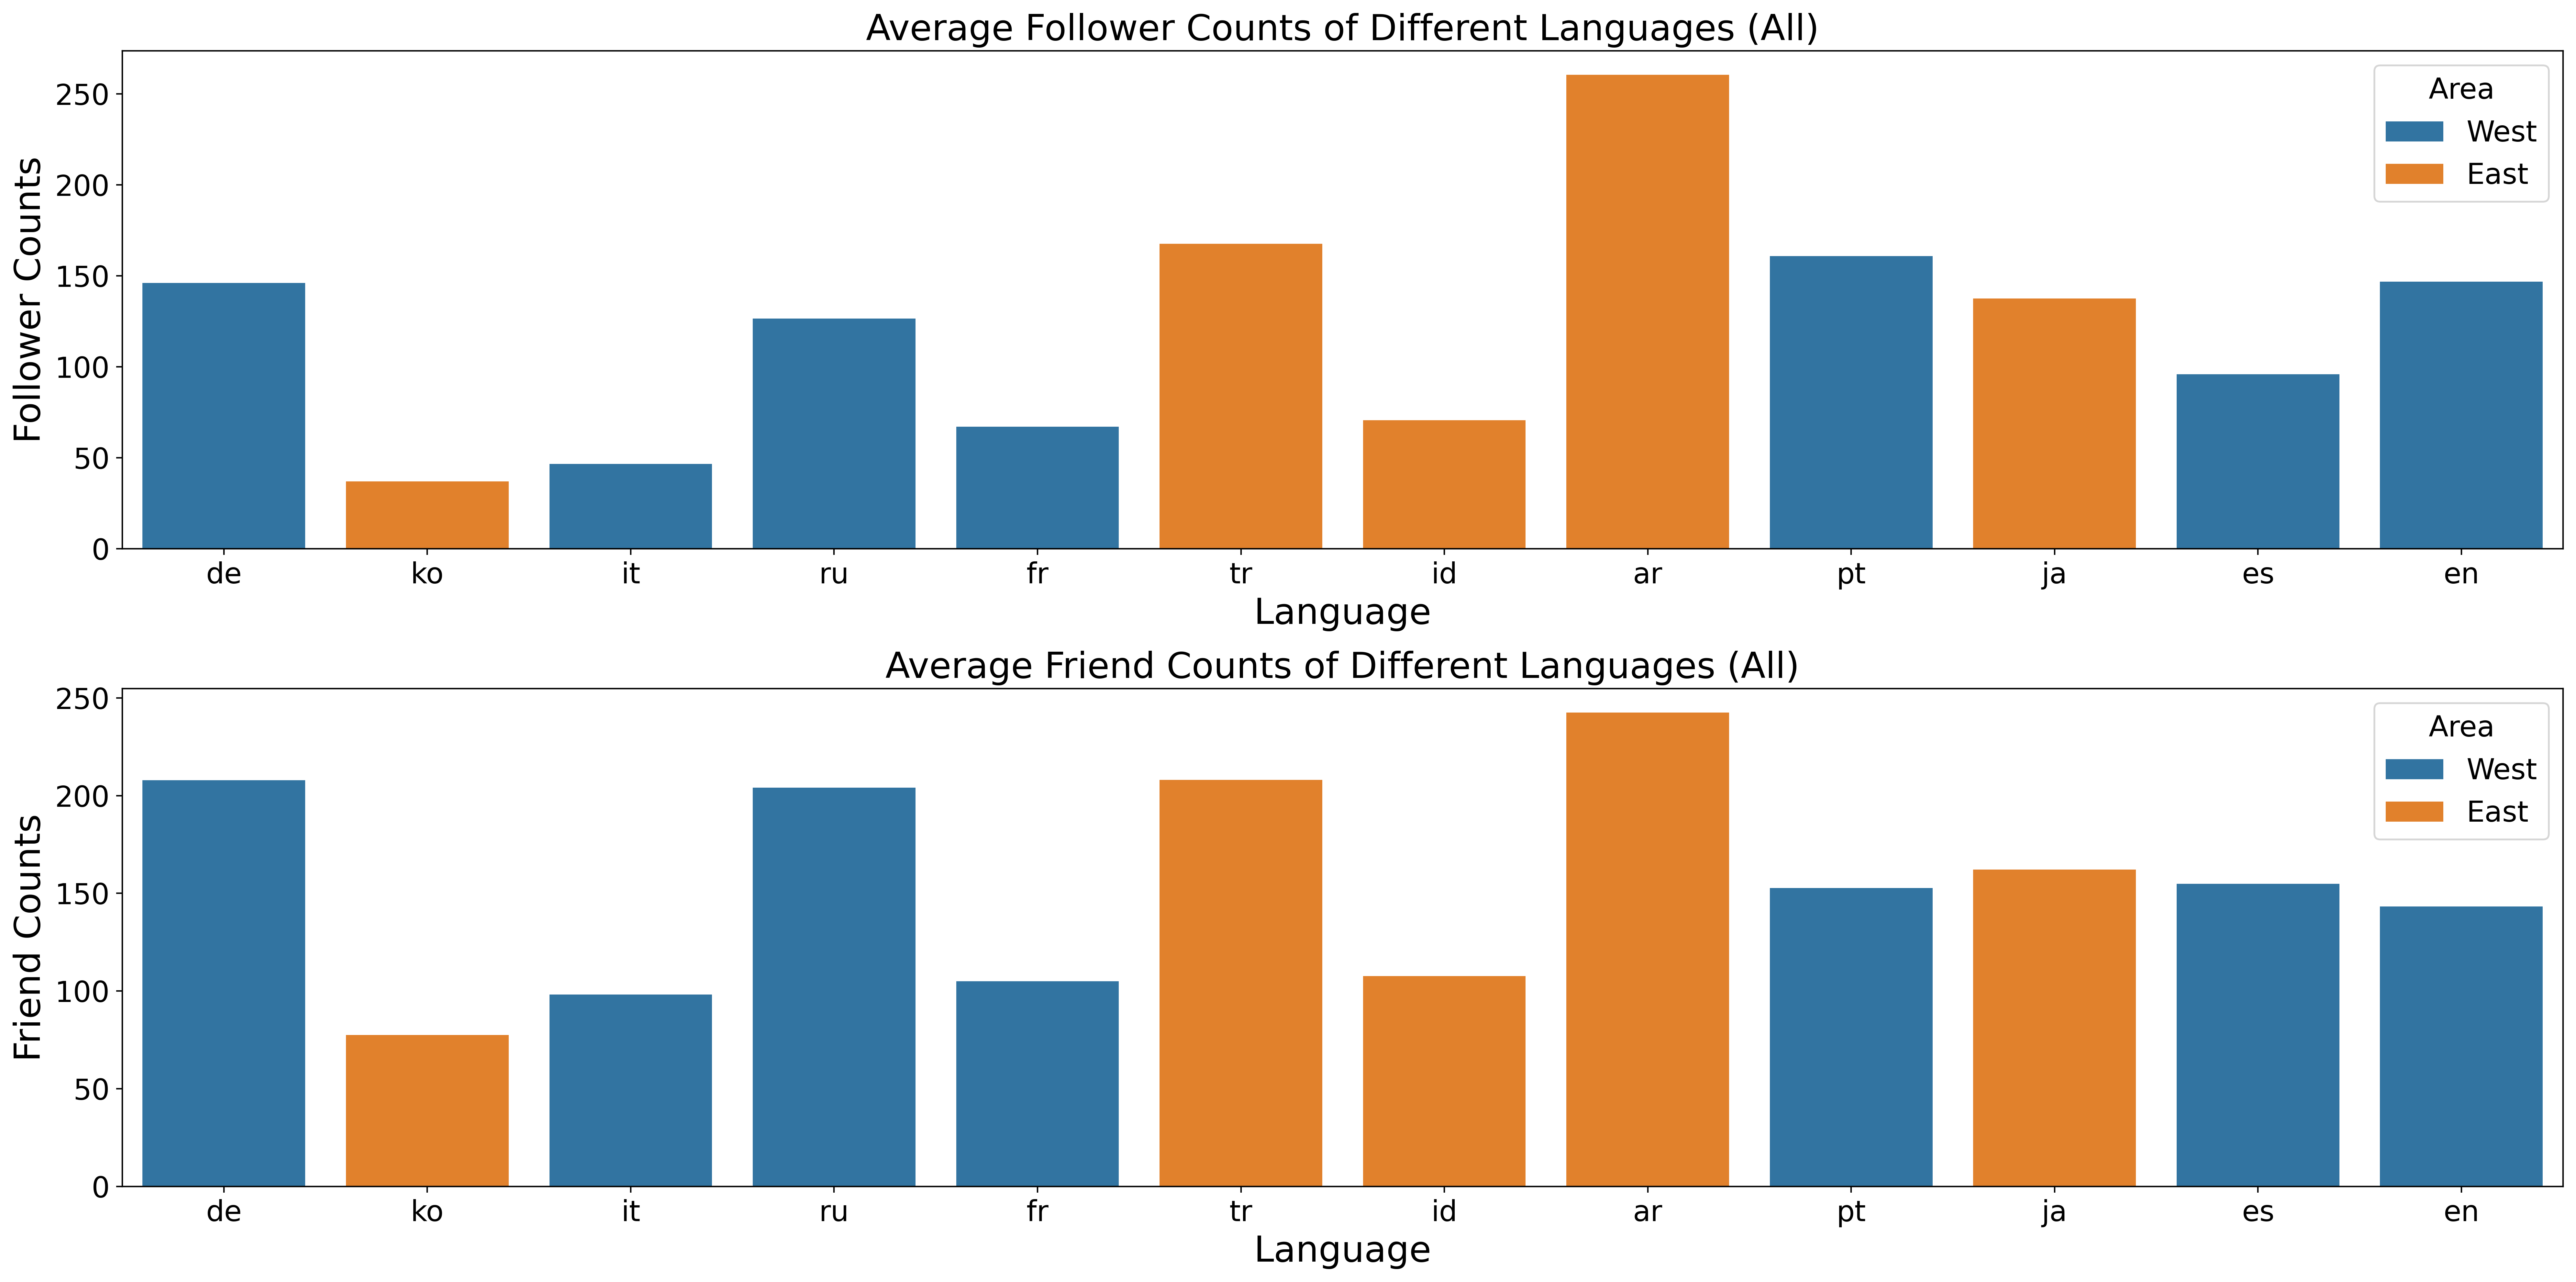

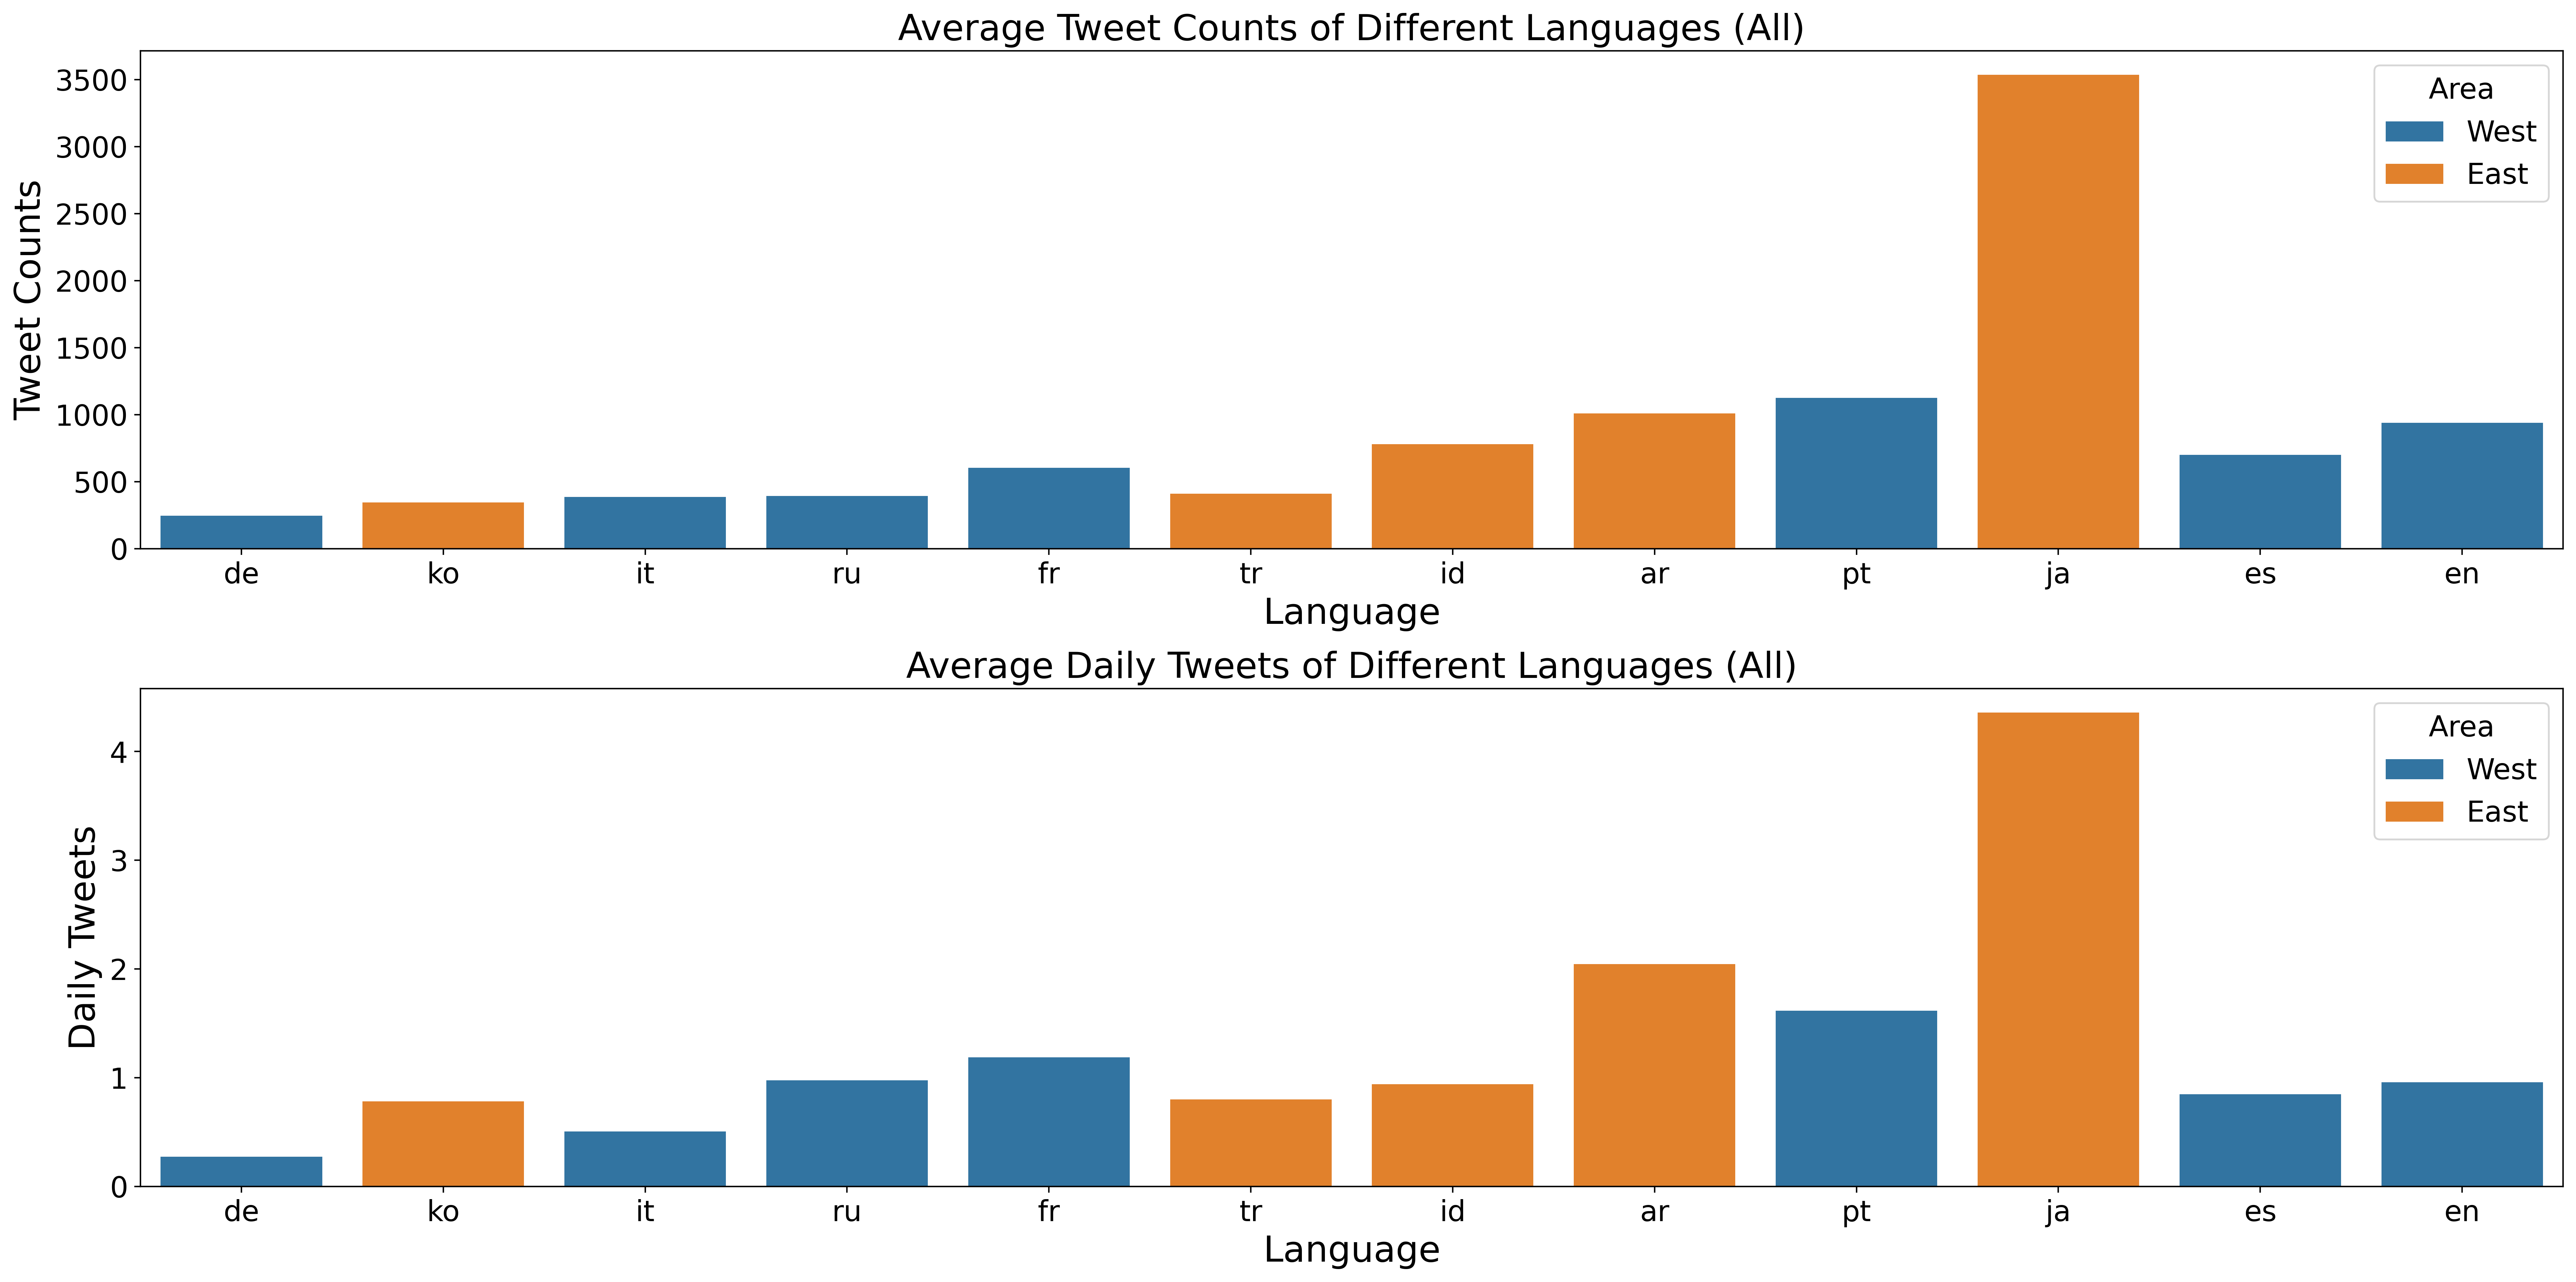

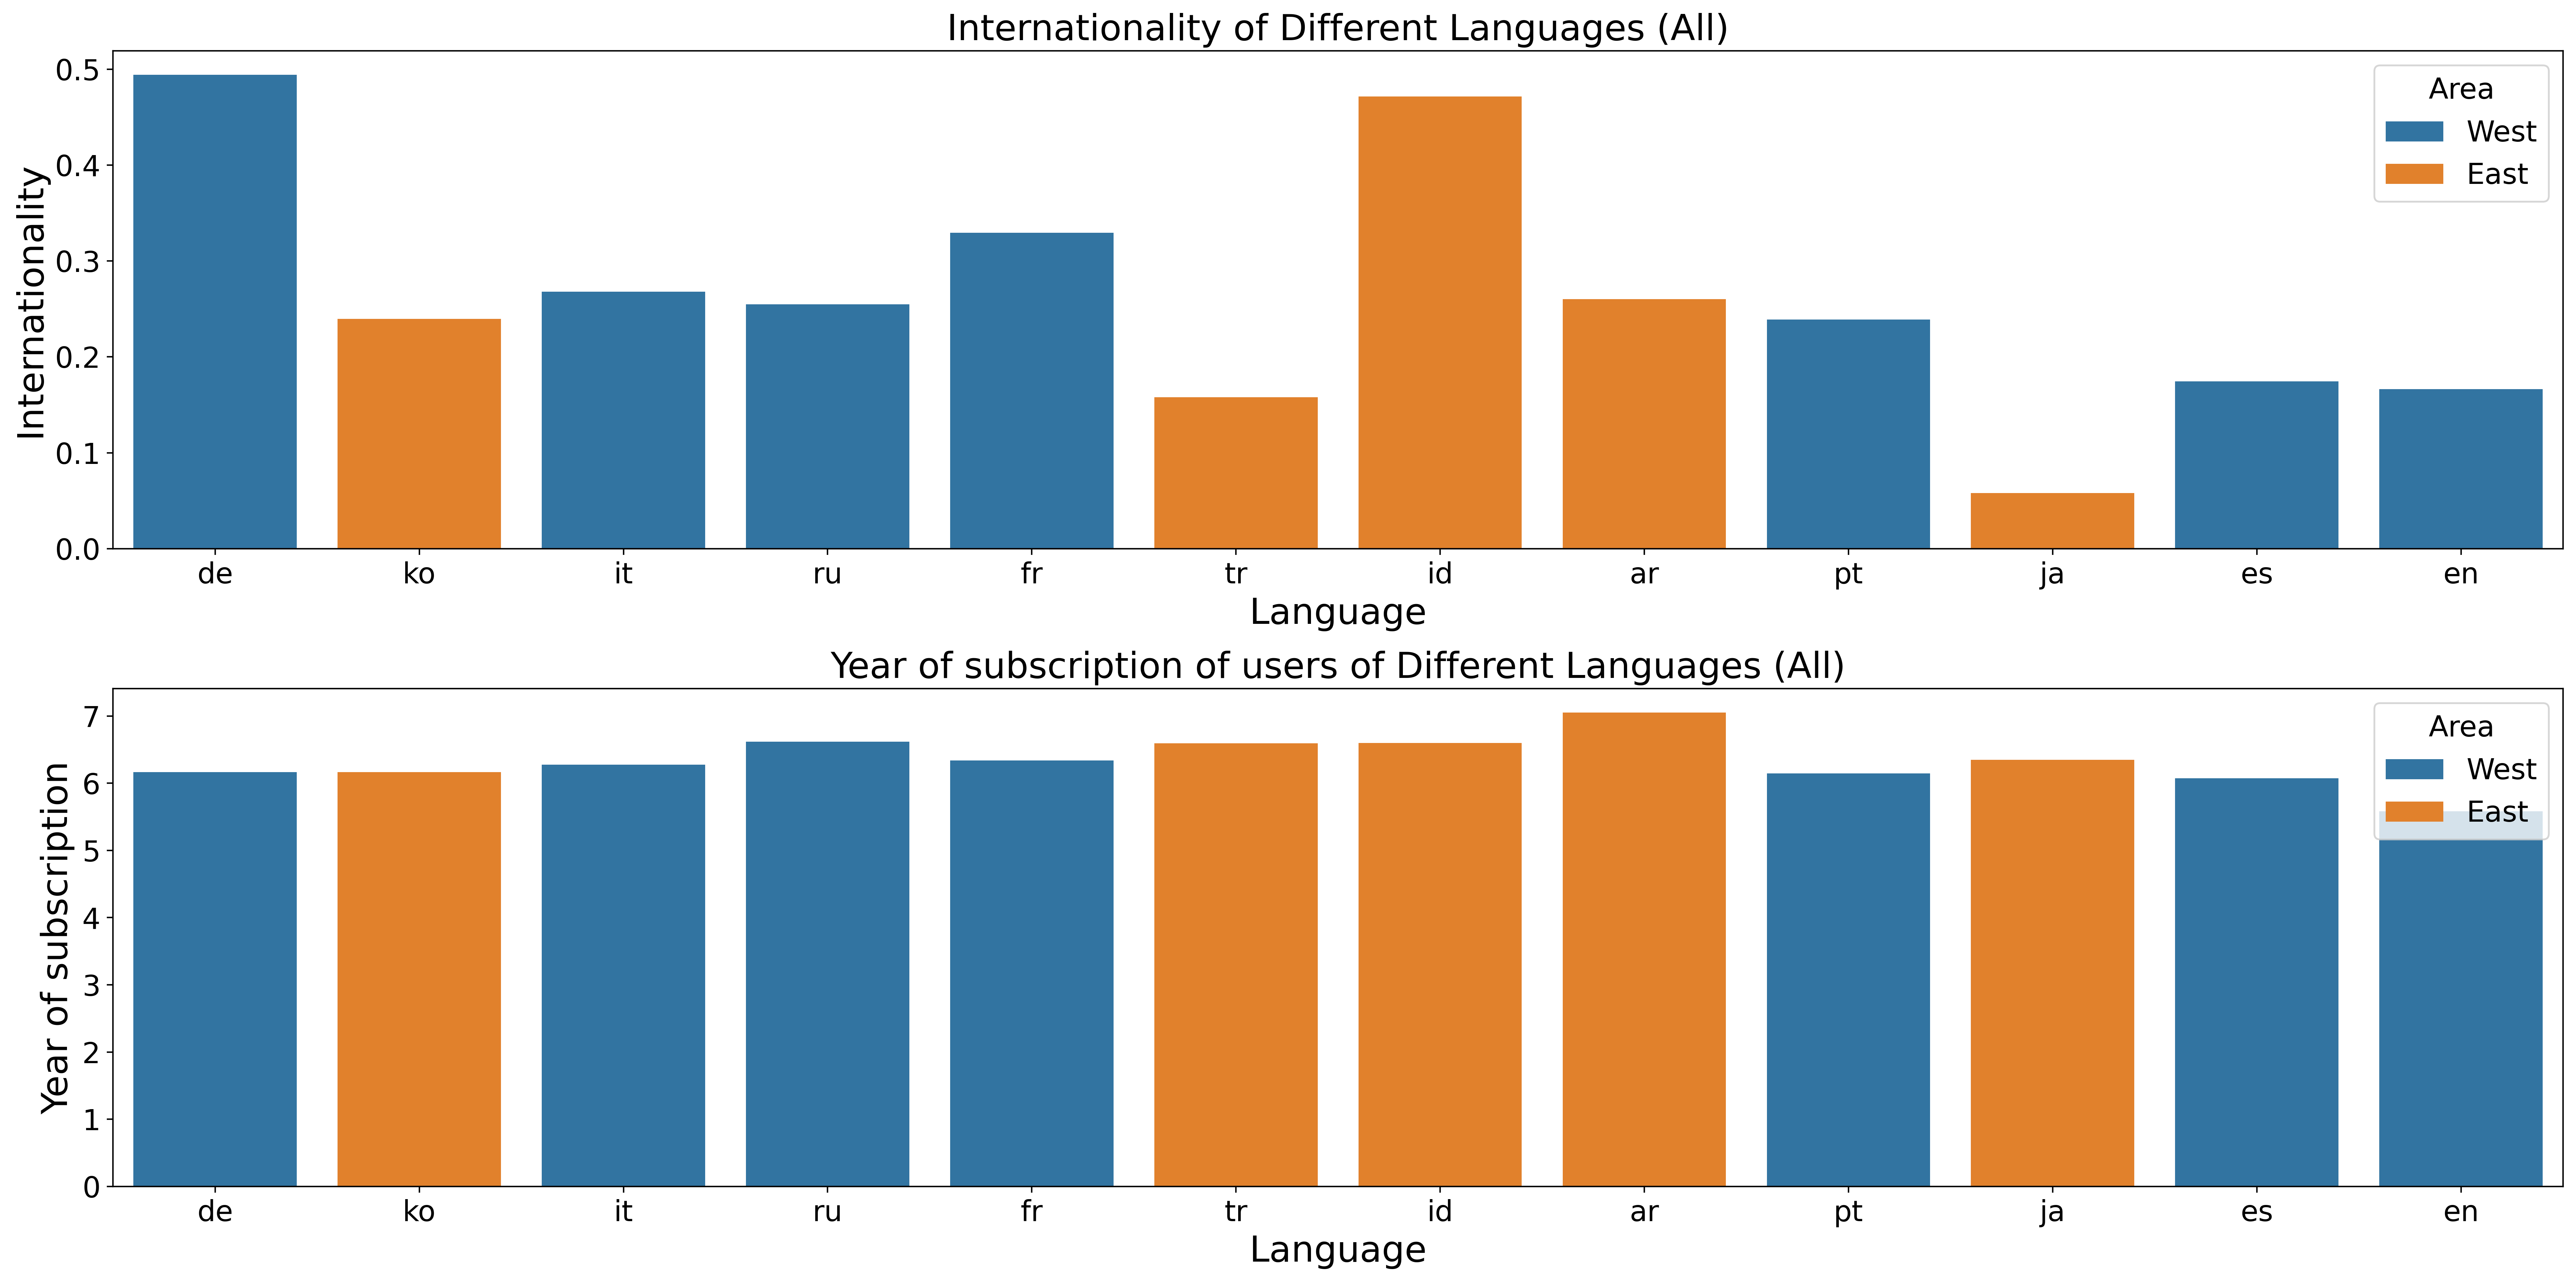

In [22]:
language_order = languages_stat.index.tolist()

fig, ax = plt.subplots(2, 1, figsize = (20, 10), dpi = 400)

#ax[0].set(yscale="log")
sns.barplot(x = languages_stat.index, y = languages_stat['followers_count'], hue = languages_stat['area'], ax = ax[0],
           dodge = False)
ax[0].set_xlabel('Language', fontsize = 20)
ax[0].set_ylabel('Follower Counts', fontsize = 20)
ax[0].set_title('Average Follower Counts of Different Languages (All)', fontsize=20)
ax[0].xaxis.set_tick_params(labelsize=16)
ax[0].yaxis.set_tick_params(labelsize=16)
ax[0].legend(title="Area", fontsize=16, title_fontsize=16, loc = 1)

#ax[1].set(yscale="log")
sns.barplot(x = languages_stat.index, y = languages_stat['friends_count'], hue = languages_stat['area'], ax = ax[1],
           dodge = False)
ax[1].set_xlabel('Language', fontsize = 20)
ax[1].set_ylabel('Friend Counts', fontsize = 20)
ax[1].set_title('Average Friend Counts of Different Languages (All)', fontsize=20)
ax[1].xaxis.set_tick_params(labelsize=16)
ax[1].yaxis.set_tick_params(labelsize=16)
ax[1].legend(title="Area", fontsize=16, title_fontsize=16, loc = 1)

fig.tight_layout()
#plt.savefig("img/popularity_statistics_barplot.jpg")

fig, ax = plt.subplots(2, 1, figsize = (20, 10), dpi = 400)

#ax[2].set(yscale="log")
sns.barplot(x = languages_stat.index, y = languages_stat['statuses_count'], hue = languages_stat['area'], ax = ax[0],
           dodge = False)
ax[0].set_xlabel('Language', fontsize = 20)
ax[0].set_ylabel('Tweet Counts', fontsize = 20)
ax[0].set_title('Average Tweet Counts of Different Languages (All)', fontsize=20)
ax[0].xaxis.set_tick_params(labelsize=16)
ax[0].yaxis.set_tick_params(labelsize=16)
ax[0].legend(title="Area", fontsize=16, title_fontsize=16, loc = 1)

#ax[3].set(yscale="log")
sns.barplot(x = languages_stat.index, y = languages_stat['avg_daily_tweets'], hue = languages_stat['area'], ax = ax[1],
           dodge = False)
ax[1].set_xlabel('Language', fontsize = 20)
ax[1].set_ylabel('Daily Tweets', fontsize = 20)
ax[1].set_title('Average Daily Tweets of Different Languages (All)', fontsize=20)
ax[1].xaxis.set_tick_params(labelsize=16)
ax[1].yaxis.set_tick_params(labelsize=16)
ax[1].legend(title="Area", fontsize=16, title_fontsize=16, loc = 1)

fig.tight_layout()
#plt.savefig("img/activeness_statistics_barplot.jpg")

fig, ax = plt.subplots(2, 1, figsize = (20, 10), dpi = 400)

#ax[2].set(yscale="log")
sns.barplot(x = languages_stat.index, y = languages_stat['Internationality'], hue = languages_stat['area'], ax = ax[0],
           dodge = False)
ax[0].set_xlabel('Language', fontsize = 20)
ax[0].set_ylabel('Internationality', fontsize = 20)
ax[0].set_title('Internationality of Different Languages (All)', fontsize=20)
ax[0].xaxis.set_tick_params(labelsize=16)
ax[0].yaxis.set_tick_params(labelsize=16)
ax[0].legend(title="Area", fontsize=16, title_fontsize=16, loc = 1)

#ax[3].set(yscale="log")
sns.barplot(x = languages_stat.index, y = languages_stat['year'], hue = languages_stat['area'], ax = ax[1],
           dodge = False)
ax[1].set_xlabel('Language', fontsize = 20)
ax[1].set_ylabel('Year of subscription', fontsize = 20)
ax[1].set_title('Year of subscription of users of Different Languages (All)', fontsize=20)
ax[1].xaxis.set_tick_params(labelsize=16)
ax[1].yaxis.set_tick_params(labelsize=16)
ax[1].legend(title="Area", fontsize=16, title_fontsize=16, loc = 1)

fig.tight_layout()
#plt.savefig("img/activeness_statistics_barplot.jpg")

plt.show()

In [23]:
print("The maximum avg number of followers belong to <", languages_stat['followers_count'].idxmax(), "> language.")
print("The minimum avg number of followers belong to <", languages_stat['followers_count'].idxmin(), "> language.")

print("The maximum avg number of friends belong to <", languages_stat['friends_count'].idxmax(), "> language.")
print("The minimum avg number of friends belong to <", languages_stat['friends_count'].idxmin(), "> language.")

print("The maximum avg number of statuses belong to <", languages_stat['statuses_count'].idxmax(), "> language.")
print("The minimum avg number of statuses belong to <", languages_stat['statuses_count'].idxmin(), "> language.")

print("The maximum avg number of daily tweets belong to <", languages_stat['avg_daily_tweets'].idxmax(), "> language.")
print("The minimum avg number of daily tweets belong to <", languages_stat['avg_daily_tweets'].idxmin(), "> language.")

The maximum avg number of followers belong to < ar > language.
The minimum avg number of followers belong to < ko > language.
The maximum avg number of friends belong to < ar > language.
The minimum avg number of friends belong to < ko > language.
The maximum avg number of statuses belong to < ja > language.
The minimum avg number of statuses belong to < de > language.
The maximum avg number of daily tweets belong to < ja > language.
The minimum avg number of daily tweets belong to < de > language.


Conclusion, if any: 
1. The maximum followers and friends -> ar. They are quite popular online. 
2. The minimum followers and friends -> ko. They tend to have less online presence.
3. The maximum tweets and daily tweets -> ja. They spend a lot of time online. 
2. The minimum tweets and daily tweets -> de. They tend to be less active online. 

Beware of the log scale. 

For follower and friend counts, the box plots for all languages are approximately quite close. But the 75-100% of the counts vary drastically for some languages. These few number of famous people have an exponentially large number of followers and friends which contributes to a really high count for languages like < en >. 

For the tweets, a clear dominance of the < ja > language is visible. 

### 10. Features Distribution of Different Cultures

To figure out whether the difference exists among western countries and eastern countries. We then group the users by the area, and check the distribution of each feature.

In [24]:
languages.groupby('area')[['followers_count', 'friends_count', 'statuses_count','avg_daily_tweets']].mean().reset_index()

area  followers_count  friends_count  statuses_count  avg_daily_tweets
0  East       156.053113     175.115803     1712.532434          2.380440
1  West       133.538550     146.302359      867.578730          0.975108

In [25]:
languages.groupby('area')[['followers_count', 'friends_count', 'statuses_count','avg_daily_tweets']].median().reset_index()

area  followers_count  friends_count  statuses_count  avg_daily_tweets
0  East             15.0             43            29.0          0.078431
1  West              9.0             38            13.0          0.021374

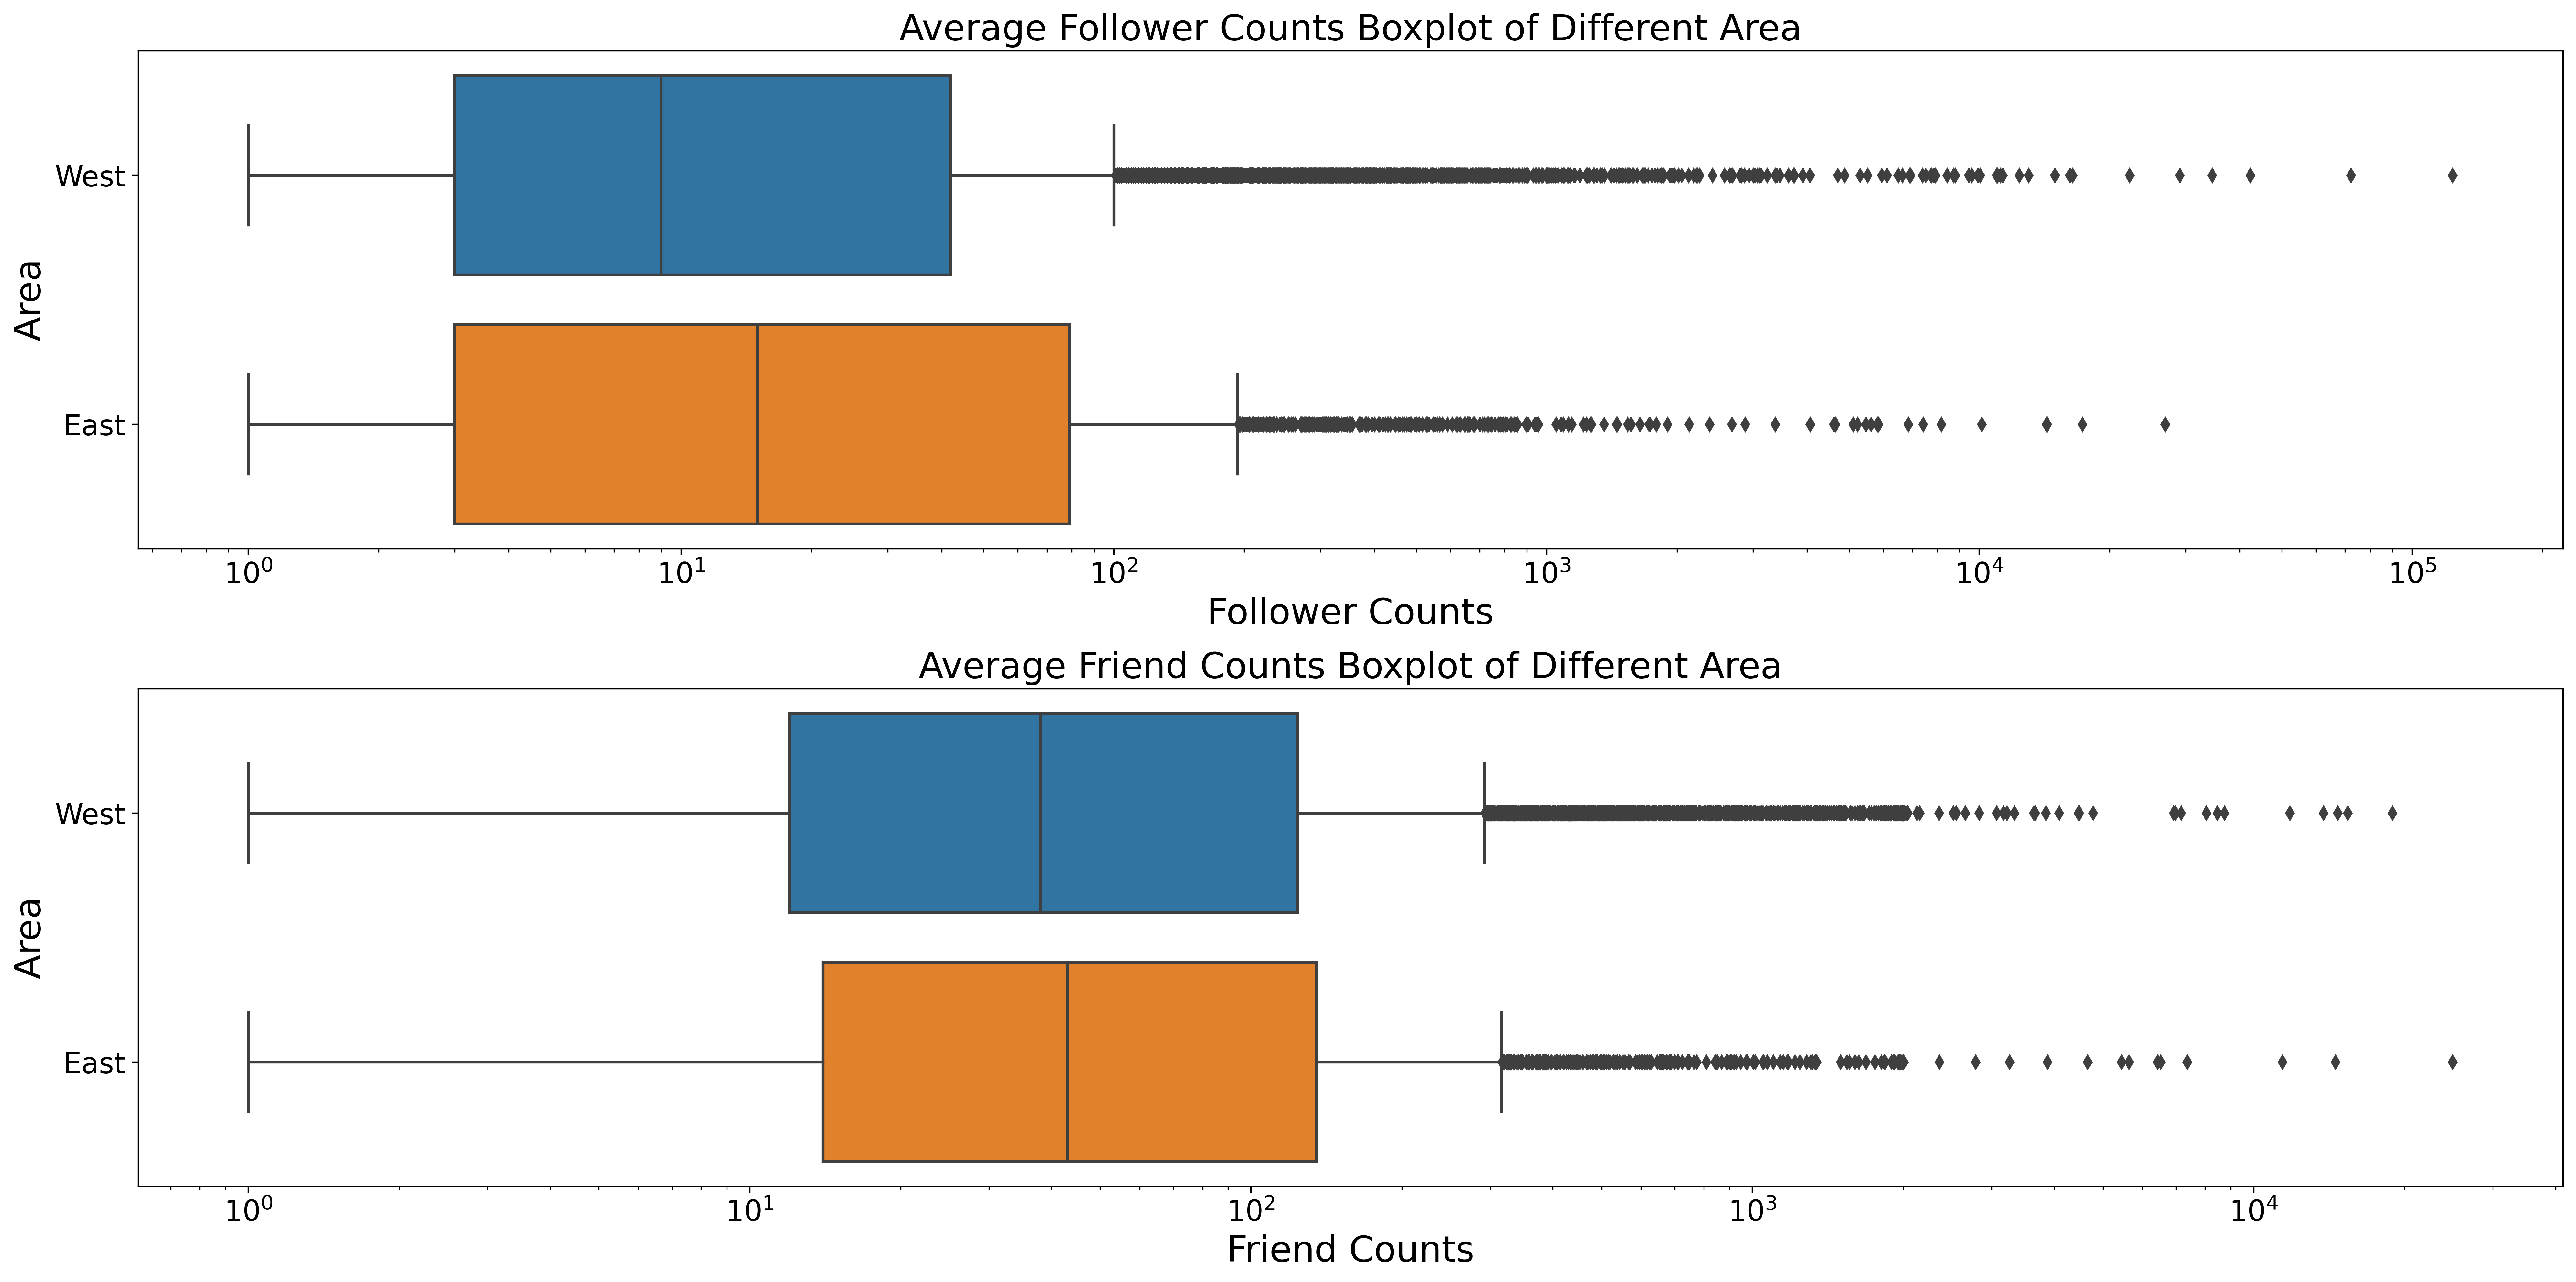

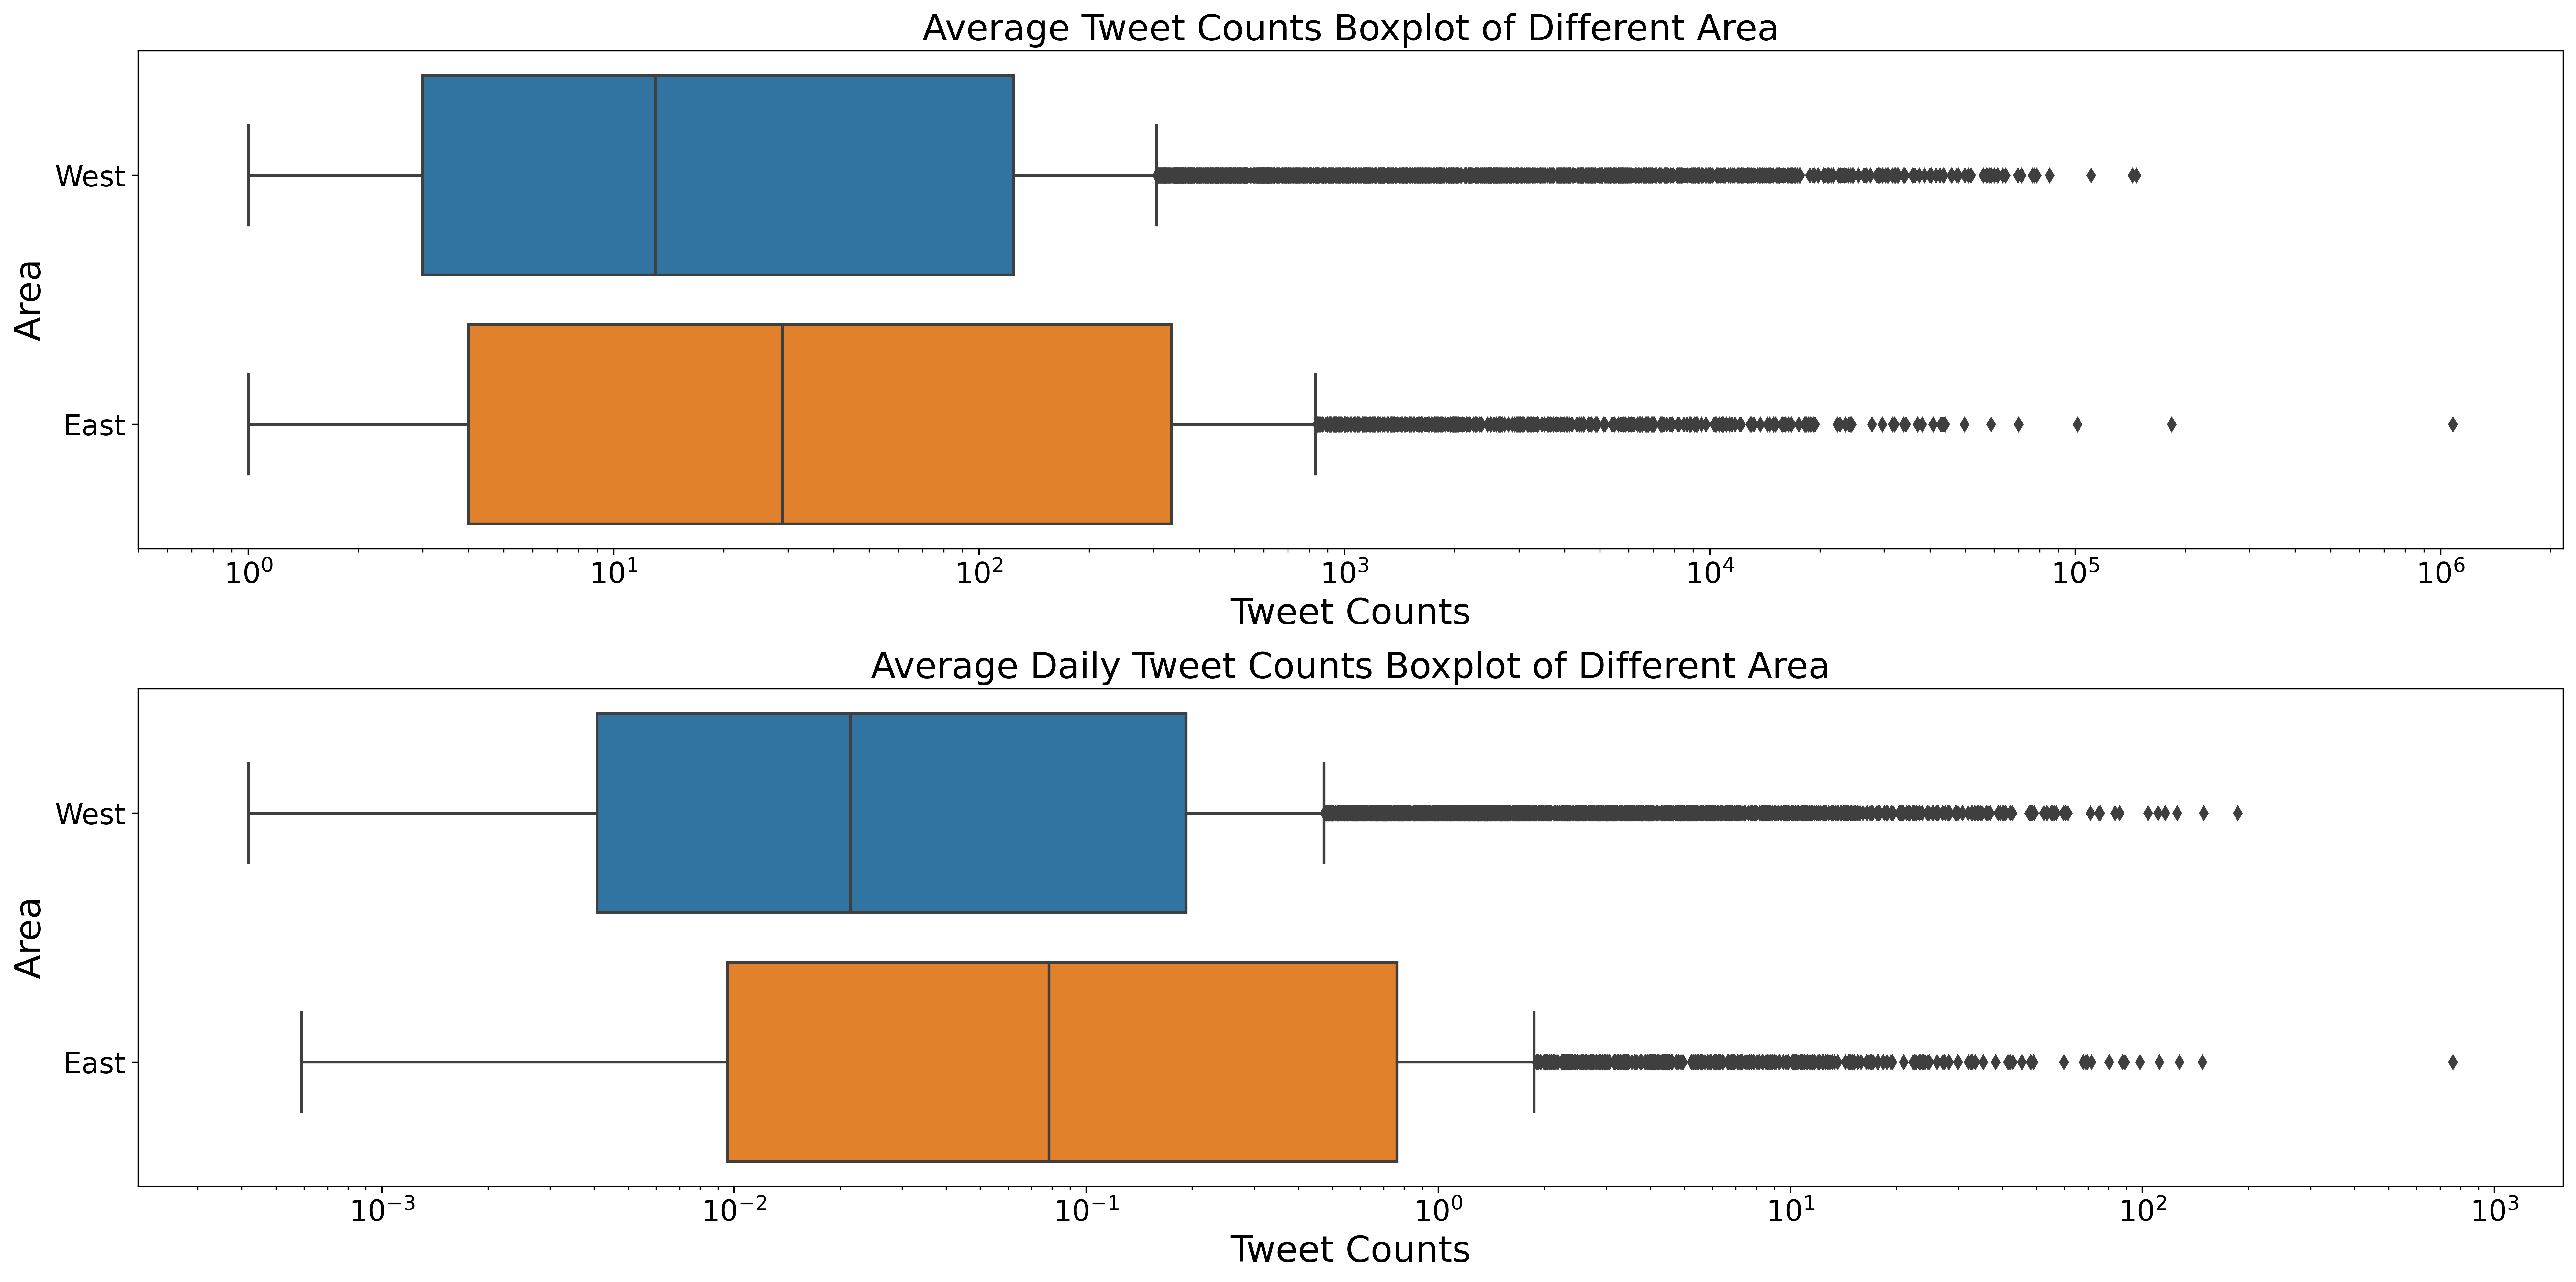

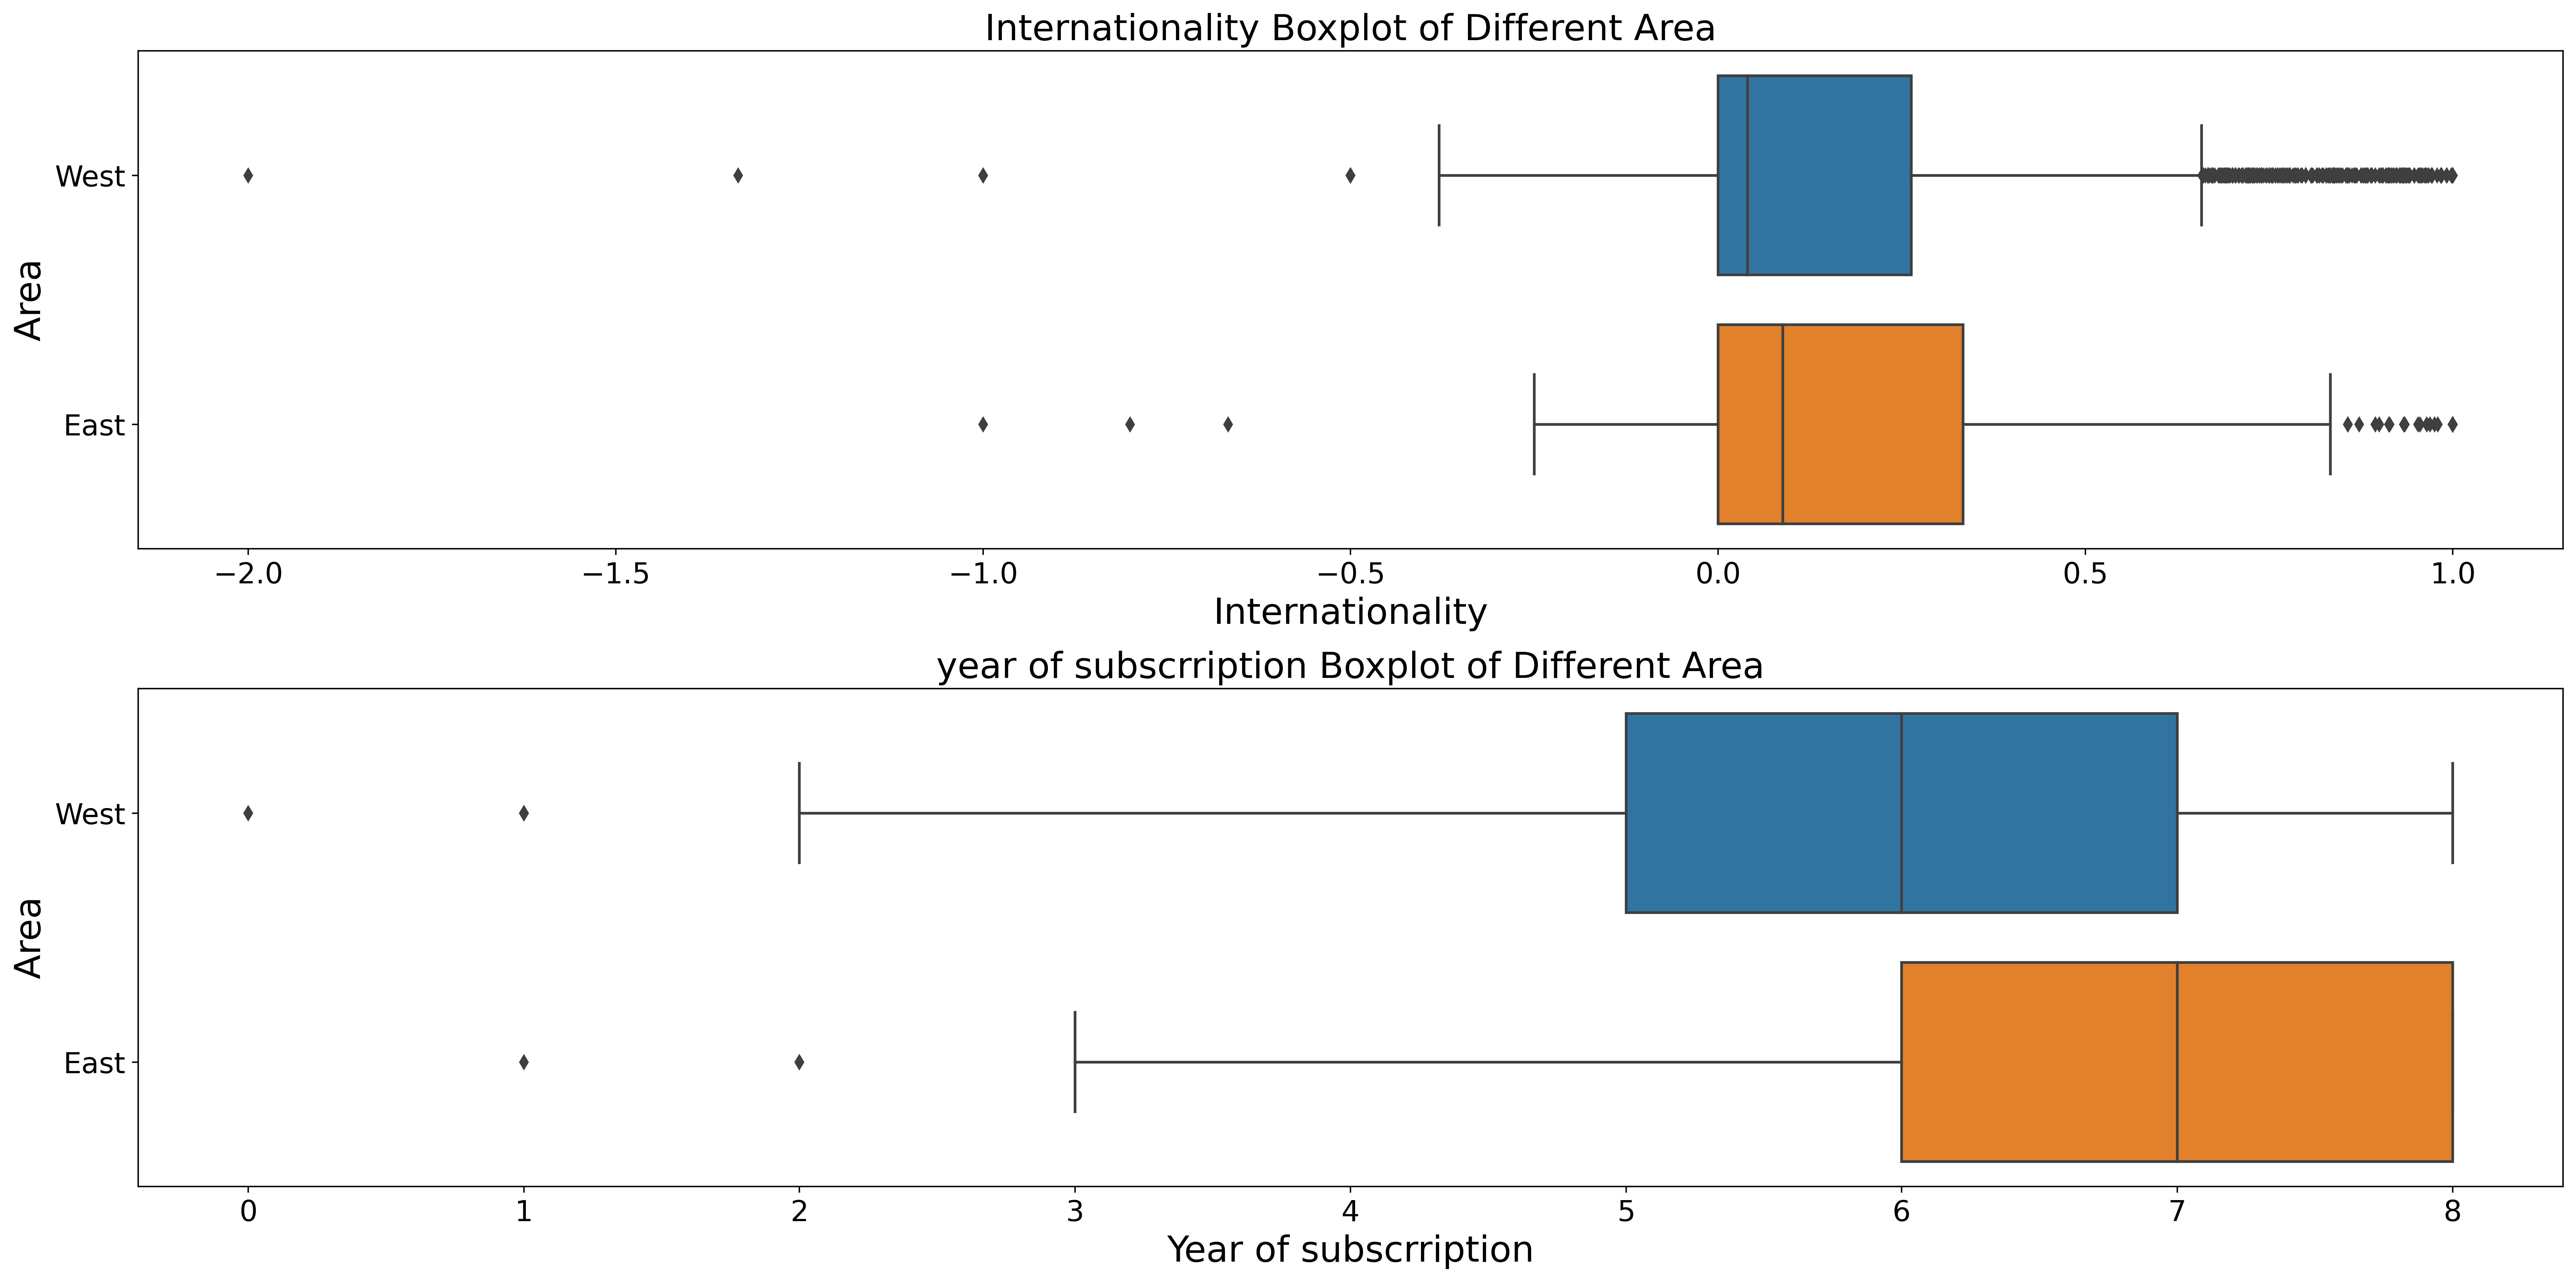

In [26]:
fig, ax = plt.subplots(2, 1, figsize = (20, 10), dpi = 400)

ax[0].set(xscale="log")
sns.boxplot( x = 'followers_count', y = 'area', data = languages, ax = ax[0])
ax[0].set_xlabel('Follower Counts', fontsize = 20)
ax[0].set_ylabel('Area', fontsize = 20)
ax[0].set_title('Average Follower Counts Boxplot of Different Area', fontsize=20)
ax[0].xaxis.set_tick_params(labelsize=16)
ax[0].yaxis.set_tick_params(labelsize=16)

ax[1].set(xscale="log")
sns.boxplot( x = 'friends_count', y = 'area', data = languages, ax = ax[1])
ax[1].set_xlabel('Friend Counts', fontsize = 20)
ax[1].set_ylabel('Area', fontsize = 20)
ax[1].set_title('Average Friend Counts Boxplot of Different Area', fontsize=20)
ax[1].xaxis.set_tick_params(labelsize=16)
ax[1].yaxis.set_tick_params(labelsize=16)

fig.tight_layout()
#plt.savefig("img/culture_popularity_boxplot.jpg")
plt.show()

fig, ax = plt.subplots(2, 1, figsize = (20, 10), dpi = 400)


ax[0].set(xscale="log")
sns.boxplot( x = 'statuses_count', y = 'area',  data = languages, ax = ax[0])
ax[0].set_xlabel('Tweet Counts', fontsize = 20)
ax[0].set_ylabel('Area', fontsize = 20)
ax[0].set_title('Average Tweet Counts Boxplot of Different Area', fontsize=20)
ax[0].xaxis.set_tick_params(labelsize=16)
ax[0].yaxis.set_tick_params(labelsize=16)

ax[1].set(xscale="log")
sns.boxplot( x = 'avg_daily_tweets', y = 'area',  data = languages, ax = ax[1])
ax[1].set_xlabel('Tweet Counts', fontsize = 20)
ax[1].set_ylabel('Area', fontsize = 20)
ax[1].set_title('Average Daily Tweet Counts Boxplot of Different Area', fontsize=20)
ax[1].xaxis.set_tick_params(labelsize=16)
ax[1].yaxis.set_tick_params(labelsize=16)

fig.tight_layout()
#plt.savefig("img/culture_activeness_boxplot.jpg")
plt.show()

fig.tight_layout()
#plt.savefig("img/culture_popularity_boxplot.jpg")
plt.show()


fig, ax = plt.subplots(2, 1, figsize = (20, 10), dpi = 400)


#ax[0].set(xscale="log")
sns.boxplot( x = 'Internationality', y = 'area',  data = languages, ax = ax[0])
ax[0].set_xlabel('Internationality', fontsize = 20)
ax[0].set_ylabel('Area', fontsize = 20)
ax[0].set_title('Internationality Boxplot of Different Area', fontsize=20)
ax[0].xaxis.set_tick_params(labelsize=16)
ax[0].yaxis.set_tick_params(labelsize=16)

#ax[1].set(xscale="log")
sns.boxplot( x = 'year', y = 'area',  data = languages, ax = ax[1])
ax[1].set_xlabel('Year of subscrription', fontsize = 20)
ax[1].set_ylabel('Area', fontsize = 20)
ax[1].set_title('year of subscrription Boxplot of Different Area', fontsize=20)
ax[1].xaxis.set_tick_params(labelsize=16)
ax[1].yaxis.set_tick_params(labelsize=16)

fig.tight_layout()
#plt.savefig("img/culture_activeness_boxplot.jpg")
plt.show()

There is a more even distribution of followers, friends and tweets in the eastern culture compared to the western culture. 
A larger proportion of counts belong to the top 25% users in the western culture, implying dominance by some famous users. 

For the number of tweets, there is a single point with surprisingly high number of tweets which is very apparent in the boxplot

In [27]:
languages_east = languages[languages['area'] == 'East']
languages_west = languages[languages['area'] == 'West']

a = languages_east['followers_count'].tolist()
b = languages_west['followers_count'].tolist()
#print(stats.kstest(a, b))
print(stats.ttest_ind(a, b))

a = languages_east['friends_count'].tolist()
b = languages_west['friends_count'].tolist()
#print(stats.kstest(a, b))
print(stats.ttest_ind(a, b))

a = languages_east['statuses_count'].tolist()
b = languages_west['statuses_count'].tolist()
#print(stats.kstest(a, b))
print(stats.ttest_ind(a, b))

a = languages_east['statuses_count'].tolist()
b = languages_west['statuses_count'].tolist()
#print(stats.kstest(a, b))
print(stats.ttest_ind(a, b))

Ttest_indResult(statistic=0.6308383756768815, pvalue=0.5281575398037914)
Ttest_indResult(statistic=2.303777320193028, pvalue=0.02125118471161755)
Ttest_indResult(statistic=3.3911618079130914, pvalue=0.0006980872068588502)
Ttest_indResult(statistic=3.3911618079130914, pvalue=0.0006980872068588502)


## Using Behavior Analysis

To delve deeper into the difference between eastern contries and western countries, we then try to reproduce some figures in the paper but group it by different cultures.

### 1. 80-20 rule

Figures show the distribution of eastern countries and western countries are almost the same.

In [28]:
user_profiles = pd.read_csv(EGO_PROFILE_PATH, sep = '\t')

In [29]:
user_profiles = user_profiles[user_profiles['IsEgo'] == True]
user_profiles['lang'] = user_profiles['lang'].str.lower()

In [30]:
western_language = ['bg', 'ca', 'cs', 'da', 'de', 'el', 'en', 'en-au', 'en-gb', 'es', 'es-mx', 'eu', 'fa',
                 'fi',  'fr', 'he', 'hi', 'hr', 'hu',   'it', 'ka', 'lv', 'nb', 'nl', 'no', 'pl', 'pt',
                 'pt-pt', 'ro', 'ru', 'sr', 'sv', 'uk']

eastern_langauge = ['ar', 'az', 'fil', 'id', 'in', 'ja', 'ko', 'ms', 'msa', 'th', 'tr', 'vi' , 'zh', 'zh-cn',
                    'zh-hans', 'zh-hant', 'zh-tw']

In [31]:
# filter the ego user and sort it by 'statuses_count'
ego = user_profiles[user_profiles['IsEgo'] == True]
ego_west = user_profiles[user_profiles['lang'].isin(western_language)]
ego_west = ego_west.sort_values(by = ['statuses_count'], ascending = False).reset_index(drop=True)

ego_east = user_profiles[user_profiles['lang'].isin(eastern_language)]
ego_east = ego_east.sort_values(by = ['statuses_count'], ascending = False).reset_index(drop=True)

# check the number of egos and the data
#print(ego_west.shape)
#ego_west.head()

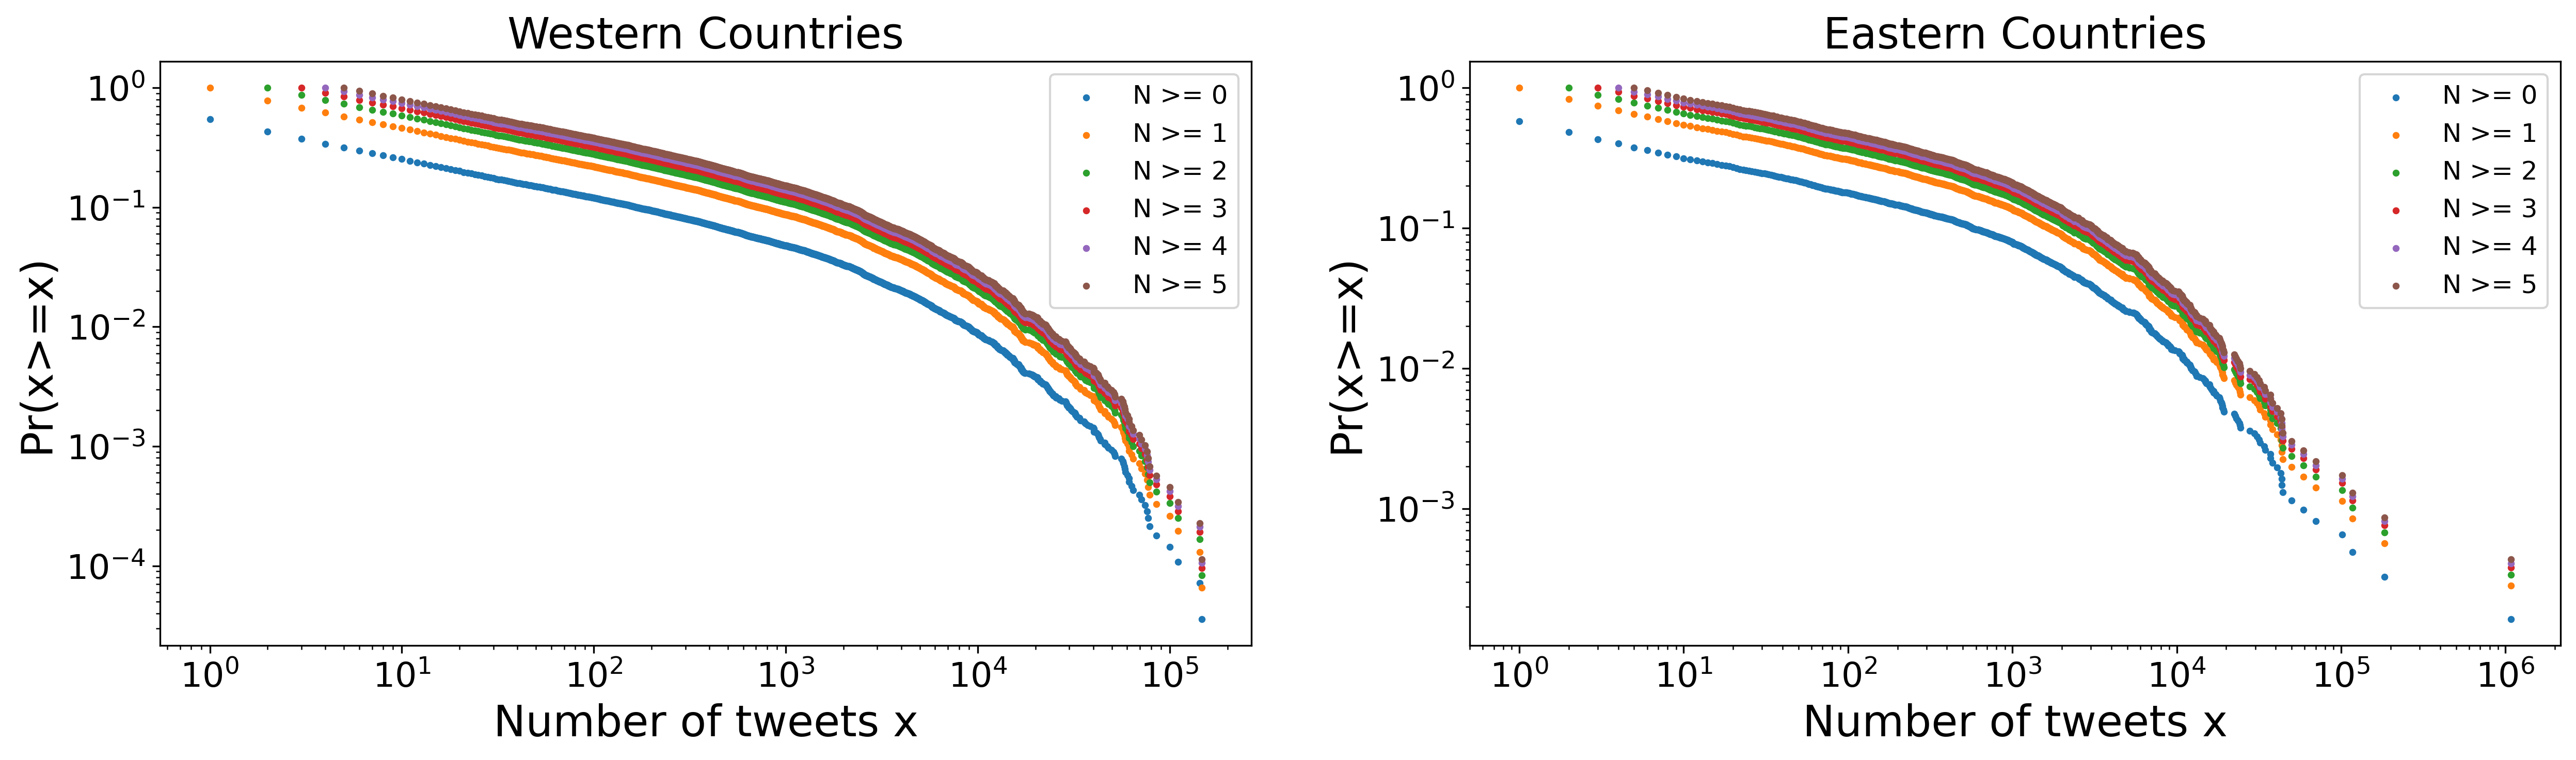

In [32]:
# prepare for the plot

fig, ax = plt.subplots(1, 2, figsize = (20, 5), dpi = 300)

# western plot

ax[0].set_title('Western Countries', fontsize = 20)
ax[0].set_xlabel('Number of tweets x', fontsize=20)
ax[0].set_ylabel('Pr(x>=x)', fontsize=20)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].xaxis.set_tick_params(labelsize=16)
ax[0].yaxis.set_tick_params(labelsize=16)

# calculate the number of people for each tweet counts 
temp = ego_west.groupby(ego_west['statuses_count']).count()['ID']
temp = temp.sort_index(ascending = False)

# loop the threshold from 0 to 5
for N in range(0, 6):
    temp = temp[temp.index >= N]
    tweet = temp.index.to_list()
    count = temp.to_list()
    total = np.sum(count)
    
    # cumulate tweet counts
    for i in range(1, len(tweet)):
        count[i]+=count[i-1]
    
    # calculate the ccdf for x (divide cumulated tweet counts by total number of tweets)
    for i in range(len(tweet)):
        count[i]/=total
    
    ax[0].scatter(tweet, count, s = 5, label = 'N >= {}'.format(N))

ax[0].legend(title="", fontsize=12, title_fontsize=12, loc = 1)

# eastern plot

ax[1].set_title('Eastern Countries', fontsize = 20)
ax[1].set_xlabel('Number of tweets x', fontsize=20)
ax[1].set_ylabel('Pr(x>=x)', fontsize=20)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].xaxis.set_tick_params(labelsize=16)
ax[1].yaxis.set_tick_params(labelsize=16)

# calculate the number of people for each tweet counts 
temp = ego_east.groupby(ego_east['statuses_count']).count()['ID']
temp = temp.sort_index(ascending = False)

# loop the threshold from 0 to 5
for N in range(0, 6):
    temp = temp[temp.index >= N]
    tweet = temp.index.to_list()
    count = temp.to_list()
    total = np.sum(count)
    
    # cumulate tweet counts
    for i in range(1, len(tweet)):
        count[i]+=count[i-1]
    
    # calculate the ccdf for x (divide cumulated tweet counts by total number of tweets)
    for i in range(len(tweet)):
        count[i]/=total
    
    ax[1].scatter(tweet, count, s = 5, label = 'N >= {}'.format(N))

ax[1].legend(title="", fontsize=12, title_fontsize=12, loc = 1)

#plt.savefig("img/tweets_per_user_distribution.jpg")
plt.show()

The distribution of number of tweets per user is quite similar for both. And the law of 80-20% is still plausible. 

### 2. Daily and Weekly Rhythms of Twitter Activity

In [33]:
ego_timeline = pd.read_csv(EGO_TIMELINE_PATH, sep = '\t', encoding='latin-1')

Create a new column to save the time as a datetime object.

In [34]:
from datetime import datetime, timedelta

def convert_time(s: str):
    '''
    convert twitter time string format to a datetime object
    '''
    new_time = datetime.strptime(s, '%a %b %d %H:%M:%S %z %Y')
    return new_time

ego_timeline['time'] = ego_timeline['created_at'].astype('str').apply(convert_time)

Calibrate the time by utc offset.

In [35]:
# create a dictionary to map egoID to utc offset
ego['utc_offset'] = ego['utc_offset'].fillna(0)
offset = dict(zip(ego['ID'], ego['utc_offset']))

def get_offset(ID):
    '''
    obtain the utc offset from the dictionary by ID
    '''
    return offset[ID]

def convert_to_timedelta(s):
    '''
    convert float to timedelta datatype
    '''
    return timedelta(seconds = s)

# create a new column which represents the required offset
ego_timeline['utc_offset'] = ego_timeline['egoID'].apply(get_offset)

# add the offset to the time column
ego_timeline['time'] = ego_timeline['time'] + ego_timeline['utc_offset'].apply(convert_to_timedelta)

Extract week day and hour from the time column for later usage

In [36]:
def get_week_day(dt):
    return dt.strftime('%a')

def get_time(dt):
    return int(dt.strftime("%H"))

ego_timeline['week_day'] = ego_timeline['time'].apply(get_week_day)
ego_timeline['hour'] = ego_timeline['time'].apply(get_time)

#ego_timeline.head()

Create two new dataframe for tweet counts and active user counts.

In [37]:
ego_lang = dict(zip(ego['ID'], ego['lang'].isin(western_language)))

def add_area(id):
    if ego_lang[id]:
        return 'west'
    else:
        return 'east'

ego_timeline['area'] = ego_timeline['egoID'].apply(add_area)
ego_timeline_west = ego_timeline[ego_timeline['area'] == 'west']
ego_timeline_east = ego_timeline[ego_timeline['area'] == 'east']

In [38]:
tweet_time_west = ego_timeline_west.groupby( [ 'week_day', 'hour'] ).size().reset_index(name = 'count')
user_time_west = ego_timeline_west.groupby( [ 'week_day', 'hour'] )['egoID'].nunique().reset_index(name = 'count')
tweet_time_east = ego_timeline_east.groupby( [ 'week_day', 'hour'] ).size().reset_index(name = 'count')
user_time_east = ego_timeline_east.groupby( [ 'week_day', 'hour'] )['egoID'].nunique().reset_index(name = 'count')

Plot the figure.

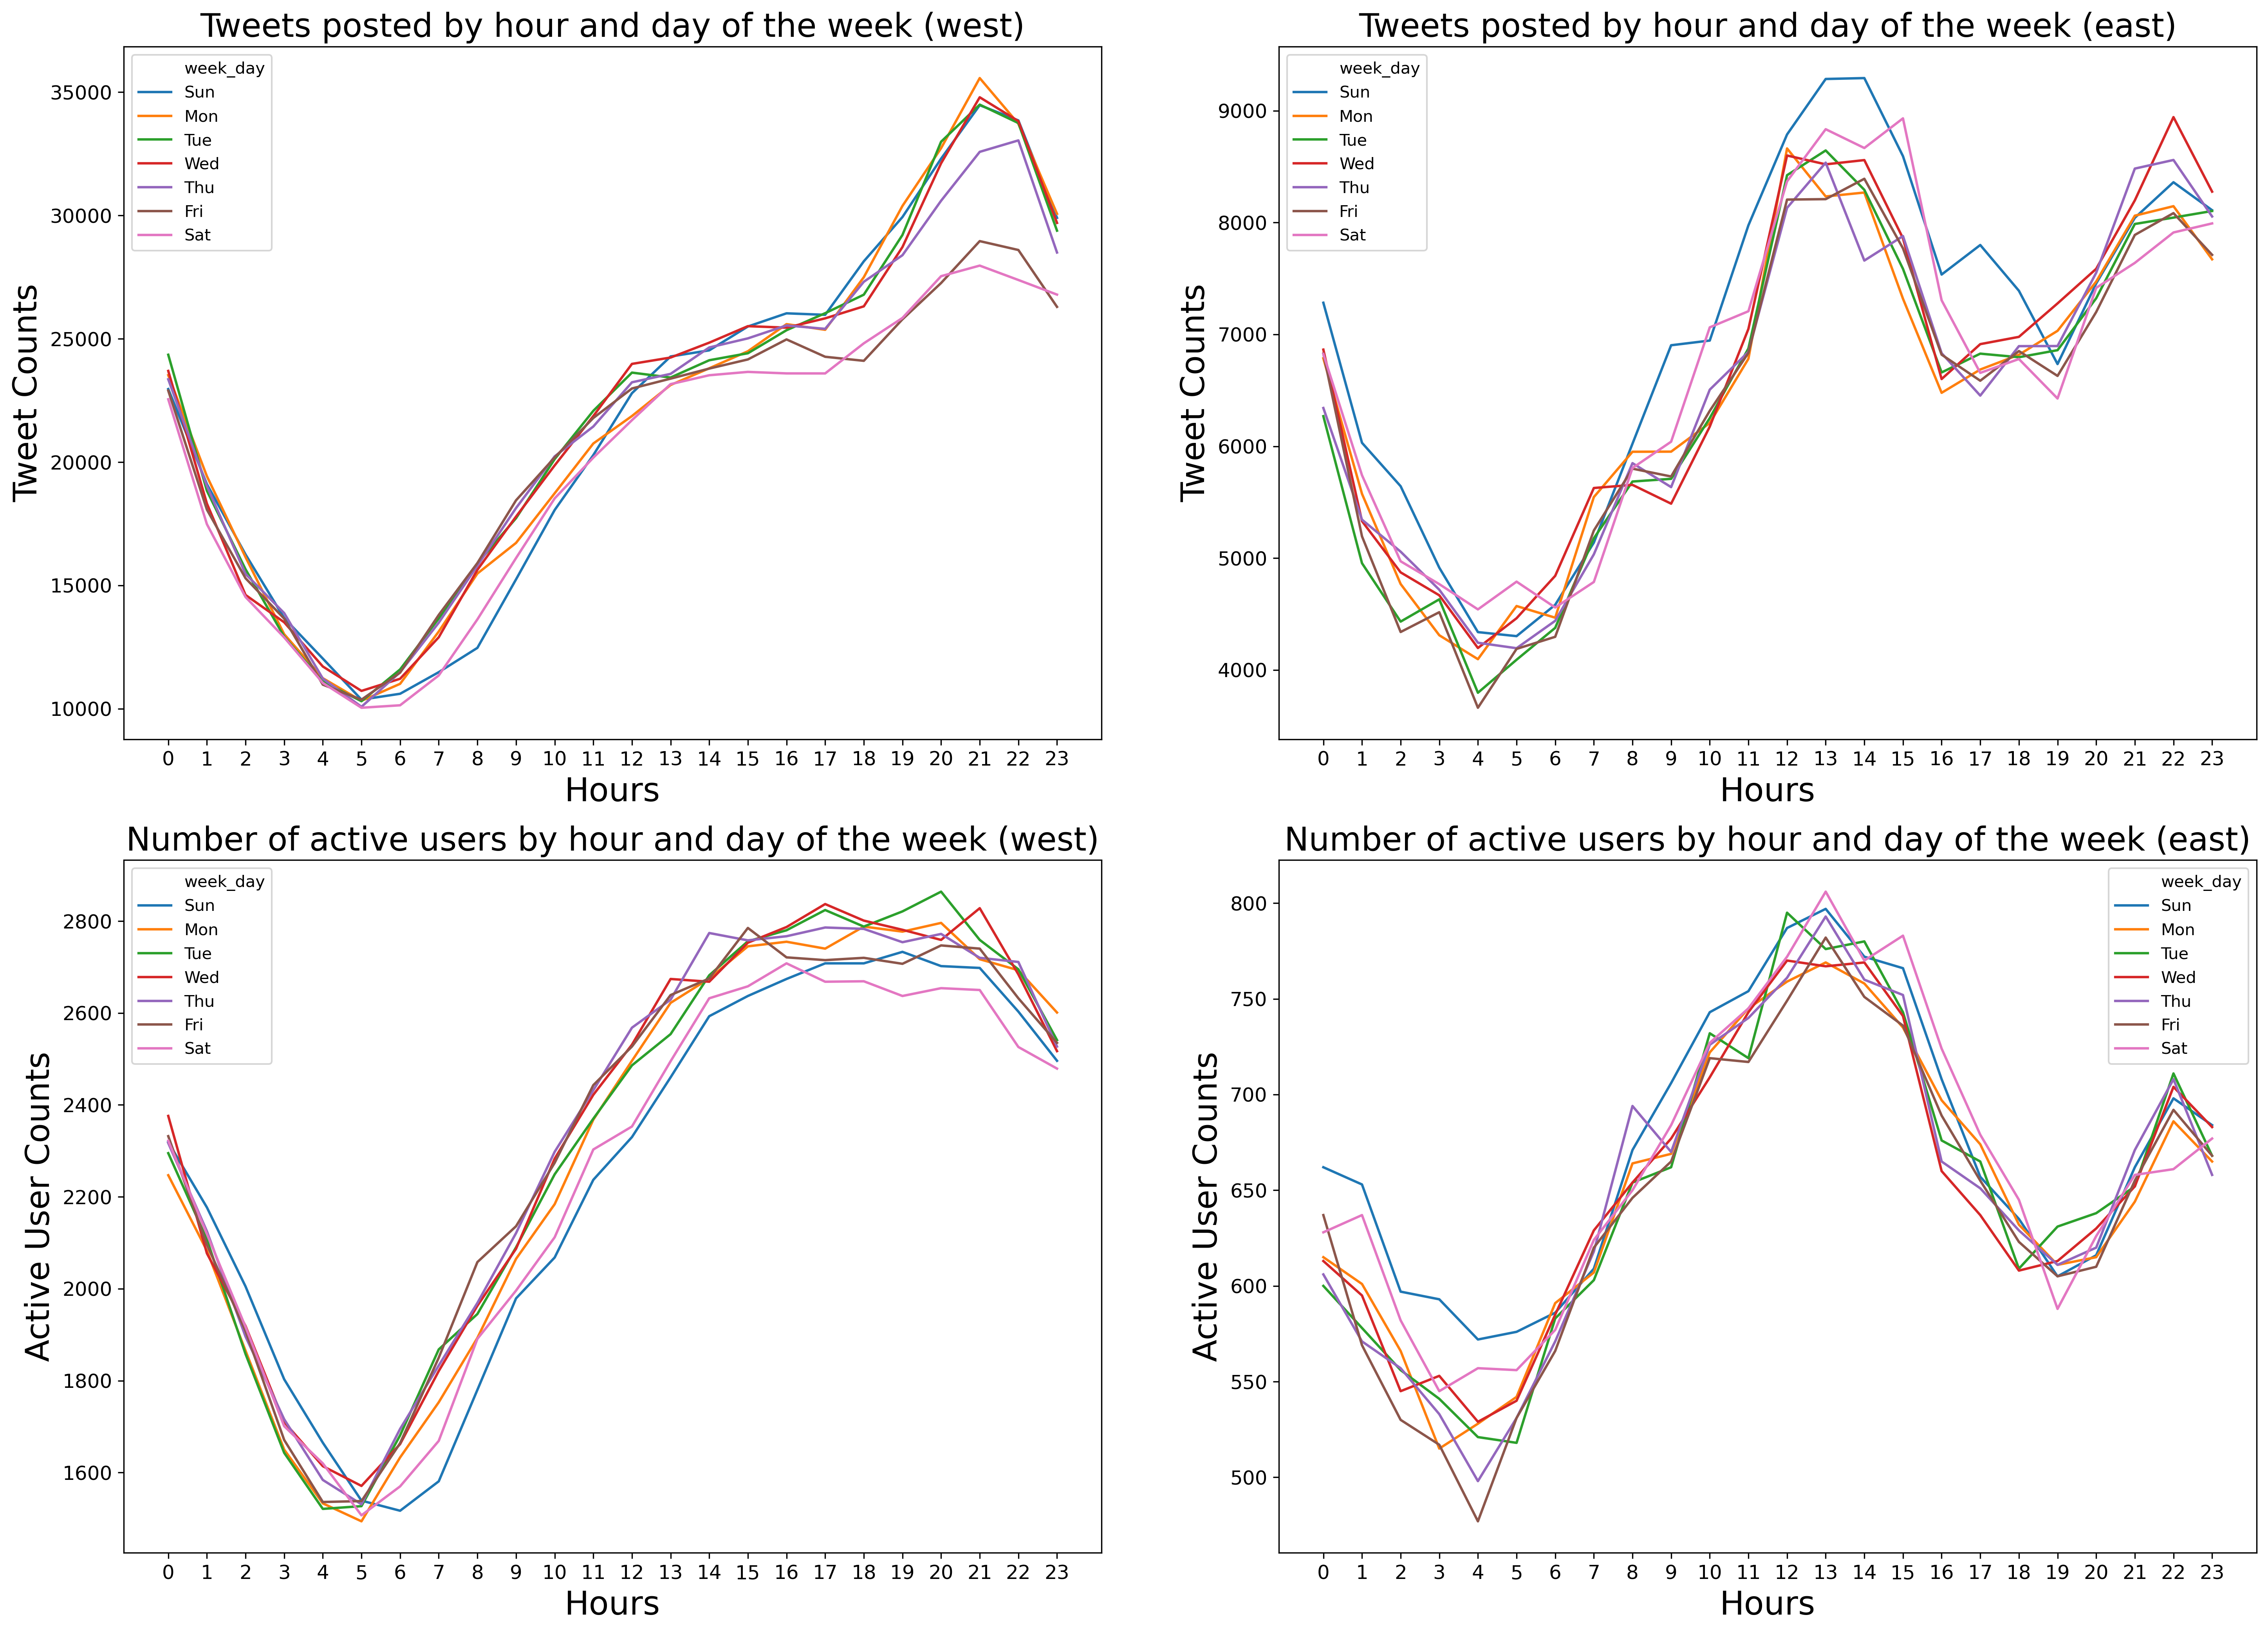

In [39]:
fig, ax = plt.subplots(2, 2, figsize = (20, 14), dpi=300)

sns.lineplot(data = tweet_time_west, x = 'hour', y = 'count', hue = 'week_day', ax = ax[0,0],
             hue_order = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
ax[0,0].set_xlabel('Hours', fontsize=20)
ax[0,0].set_ylabel('Tweet Counts', fontsize=20)
ax[0,0].set_xticks(np.arange(0, 24))
ax[0,0].set_title('Tweets posted by hour and day of the week (west)', fontsize=20)
ax[0,0].xaxis.set_tick_params(labelsize=12)
ax[0,0].yaxis.set_tick_params(labelsize=12)

sns.lineplot(data = user_time_west, x = 'hour', y = 'count', hue = 'week_day', ax = ax[1,0],
            hue_order = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
ax[1,0].set_xlabel('Hours', fontsize=20)
ax[1,0].set_ylabel('Active User Counts', fontsize=20)
ax[1,0].set_xticks(np.arange(0, 24))
ax[1,0].set_title('Number of active users by hour and day of the week (west)', fontsize=20)
ax[1,0].xaxis.set_tick_params(labelsize=12)
ax[1,0].yaxis.set_tick_params(labelsize=12)


sns.lineplot(data = tweet_time_east, x = 'hour', y = 'count', hue = 'week_day', ax = ax[0,1],
             hue_order = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
ax[0,1].set_xlabel('Hours', fontsize=20)
ax[0,1].set_ylabel('Tweet Counts', fontsize=20)
ax[0,1].set_xticks(np.arange(0, 24))
ax[0,1].set_title('Tweets posted by hour and day of the week (east)', fontsize=20)
ax[0,1].xaxis.set_tick_params(labelsize=12)
ax[0,1].yaxis.set_tick_params(labelsize=12)

sns.lineplot(data = user_time_east, x = 'hour', y = 'count', hue = 'week_day', ax = ax[1,1],
            hue_order = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
ax[1,1].set_xlabel('Hours', fontsize=20)
ax[1,1].set_ylabel('Active User Counts', fontsize=20)
ax[1,1].set_xticks(np.arange(0, 24))
ax[1,1].set_title('Number of active users by hour and day of the week (east)', fontsize=20)
ax[1,1].xaxis.set_tick_params(labelsize=12)
ax[1,1].yaxis.set_tick_params(labelsize=12)

plt.tight_layout()
#plt.savefig("img/active_time.jpg")
plt.show()

The plot for the eastern and western cultures look quite different. But they still seem to follow the circadian rythm pattern as suggested in the paper. 

But an interesting thing to note is that a peak in the number of tweets is visible around 22h for both west and east, but there is an equally high peak in the number of tweets around 13h in the east. Also, the number of active users gradually increase after 4h for both west and east. But there is a drastic dip in the number of active users between 15h and 21h in the east. The number of tweets is also less during this time in the east (Maybe this is what makes a peak at 13h visible, and there is no reason for peak at 13h but there is a reason for inactivity from 15h to 21h) --What could be the reason for this?

Also, not the difference in scales. 35k vs 9k tweets per day. 2800 vs 800 active users per day. West vs East. 

### 3. Following Preference Analysis

In [40]:
ego_network = pd.read_csv(EGO_NETWORK_PATH, sep = '\t')
ego_alter_profiles = pd.read_csv(EGO_PROFILE_PATH, sep = '\t')

In [41]:
ego_alter_list = languages_with_alter['ID'].tolist()

#ego_network = ego_network[(ego_network['followerID'].isin(ego_alter_list)) 
#                          | (ego_network['followeeID'].isin(ego_alter_list))]

#only consider ego as follower
ego_network = ego_network[(ego_network['followerID'].isin(ego_alter_list))]

ego_network.head()

NameError: name 'languages_with_alter' is not defined

In [ ]:
mapping_id_language = dict(zip(ego_alter_profiles['ID'], ego_alter_profiles['lang']))

def assign_lang(id):
    return mapping_id_language[id]

ego_network['lang1'] = ego_network['followerID'].apply(assign_lang)
ego_network['lang2'] = ego_network['followeeID'].apply(assign_lang)
ego_network['same_lang'] = np.where(ego_network['lang1'] == ego_network['lang2'], True, False)
ego_network['same_lang'].value_counts()

In [ ]:
language_order = languages_stat.index.tolist()
print(language_order)
mapping_language = dict(zip(language_order, [i for i in range(0, 12)]))

rows, cols = (12, 12) 
connection = [[0 for i in range(cols)] for j in range(rows)] 
follow_pair = list(zip(ego_network['lang1'], ego_network['lang2']))

for i, v in enumerate(follow_pair):
    if follow_pair[i][0] in language_order and follow_pair[i][1] in language_order:
        connection[mapping_language[follow_pair[i][0]]][mapping_language[follow_pair[i][1]]] += 1

connection_dataframe = pd.DataFrame(connection, columns = language_order, index = language_order)  
connection_dataframe.head(12)

In [ ]:
languages_stat

In [ ]:
for i in range(12):
    fig, ax = plt.subplots(figsize = (20, 7), dpi = 300)
    ax.set(yscale = 'log')
    splot = sns.barplot(x = languages_stat.index, y = connection[i], hue = languages_stat['area'].tolist(),
                        ax = ax, dodge = False)
    ax.set_xlabel('Language', fontsize = 20)
    ax.set_ylabel('Following Counts', fontsize = 20)
    ax.set_title('Total following counts of {} users'.format(languages_stat.index[i]), fontsize=20)
    ax.xaxis.set_tick_params(labelsize=16)
    ax.yaxis.set_tick_params(labelsize=16)
    if i >= 2:
        ax.legend(title="Area", fontsize=16, title_fontsize=16, loc = 2)
    else:
        ax.legend(title="Area", fontsize=16, title_fontsize=16, loc = 0)
    for p in splot.patches:
        splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points',
                   fontsize = 12) 
    #fig.savefig('img/language_following/language_following_counts_{}.jpg'.format(languages_stat.index[i]))

## Culture Prediction

Can we predict the culture of a user, given his/her total activity on Tweeter (without access on his/her content)?
Let's try to solve this problem in a supervised and unspervised way using all the features analyzed in Activitness Analysis session:
`followers_count, friends_count, statuses_count, Internationality, avg_daily_tweets, year`

### 1. Supervised Learning 
In a supervised framework we split the dataset in 2 part: 70\% for the training and the remaining 30\% for testing.

### Split the dataset

In [ ]:
# create the dataset
dataset = languages.drop(columns = ['ID', 'IsEgo', 'lang'])
dataset['area'] = dataset['area'].apply(lambda x: 1 if x=='West' else 0)

# 70% train, 30% test
train = dataset.sample(frac=0.7,random_state=200)
test = dataset.drop(train.index)

X_train = train.loc[:, train.columns != 'area']
y_train = train['area']
X_test = test.loc[:, test.columns != 'area']
y_test = test['area']

# show the X matrix for the training
X_train

Presprocess the data is important to guarantee a good training of the model. 
Further analysis show that a polynomial expansion don't seem to improve our prediction performance.

### Preprocessing

In [ ]:
from sklearn import preprocessing
import statsmodels.api as sm

# Polynomial feature expansion
#poly = preprocessing.PolynomialFeatures(2, include_bias=False)
#X_train = poly.fit_transform(X_train)
#X_test = poly.fit_transform(X_test)

# scalarization
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# intercept
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

The first supervised learning algorithm for classification that we test is the Logistic regression.

### Logistic Model

In [ ]:
logit_mod = sm.Logit(y_train, X_train)
logit_res = logit_mod.fit()

print(logit_res.summary())

As expected there are regressors more significant then others. In particular there is not strong statical evidence to say that the number of followers ($t-student=-1.091$, $p-value=0.275$) and friends ($t-student=1,003$, $p-value=0.316$) are significant regrossor to predict Western or Eastern culture of a user. Also the number of daily tweets ($t-student=-1.157$, $p-value=0.247$) is not not a significant regressor, but maybe because it is strong correlated with the total number of tweets published and the year of subscription.

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = np.around(logit_res.predict(X_train))
print('Accuracy Train: ', accuracy_score(y_train, y_pred))

y_pred = np.around(logit_res.predict(X_test))
print('Accuracy Test: ',accuracy_score(y_test, y_pred))

We got an accuracy on the train and test set both around 0.82. It is not outstanding but anyway it is an surpring result since we are using only few, very general, features.

Since the accuracy of the test is even better than that one on the training set we can't say that this model is not overfitting at all.

### Random Forest

The second supervised approach that we propose is a random forest. 
The dataset is already prepared and we tuned the parameter 'n_estimators' through a grid search on [100,200,...,1000].

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 500, random_state = 42)
rf.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = np.around(rf.predict(X_train))
print('Accuracy Train: ', accuracy_score(y_train, y_pred))

y_pred = np.around(rf.predict(X_test))
print('Accuracy Test: ',accuracy_score(y_test, y_pred))

The accuracy on the test set confirm the result of the losgistic regression.
However with respect to the previous model, as known, the random forest overfit a lot (see the perfect accuracy on the training)

## 2. Unsupervised Learning

A even challenging problem is to find this 2 behaviors (western and eastern) from  scratch, i.e. without a training model.
If we are able to cluster the users in this two subset without knowing that they exist, it would means that they are strong and that exist from real.

We try to cluster the dataset through k-means algorithm (k=2).
However, since our user  features belong to $R^6$ we cannot visualize it directly. We propose 2 algorithms (PCA and t-SNE) to map the dataset in $R^2$ and visualize the 2 classes expected and predicted.

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# create the dataset
X = dataset.loc[:, dataset.columns != 'area']
y = dataset['area']

# standardization
X = preprocessing.StandardScaler().fit(X).transform(X)

# map in R^2
X_reduced_tsne = TSNE(n_components=2, random_state=0).fit_transform(X)
X_reduced_pca = PCA(n_components=2).fit(X).transform(X)

# K means algorithm
predicted = KMeans(n_clusters=2, random_state=0).fit_predict(X)



fig, axs = plt.subplots(1, 2, figsize=(10,5), sharey=True)

axs[0].scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=y, alpha=0.6)
axs[0].set_title("Original Types (TSNE)")

axs[1].scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=predicted, alpha=0.6)
axs[1].set_title("Discovered clusters (TSNE)")

fig, axs = plt.subplots(1, 2, figsize=(10,5), sharey=True)

axs[0].scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=y, alpha=0.6)
axs[0].set_title("Original Types (PCA)")

axs[1].scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=predicted, alpha=0.6)
axs[1].set_title("Discovered clusters (PCA)")

However, as shown on the 2 figues on the left this clusters are (if exist) are not completely predictable with our features and the proietion in $R^2$ seems even more chaotic. For this clusters on the 2 figures on the left (with the predicted lable) are even more meaningless.

In [ ]:
# consider only the two most predictive features in agreement with t-test of logistic regression.
X = dataset[['Internationality','year']]
y = dataset['area']

predicted = KMeans(n_clusters=2, random_state=0).fit_predict(X)

fig, axs = plt.subplots(1, 2, figsize=(10,5), sharey=True)

axs[0].scatter(X.iloc[:,0], X.iloc[:,1], c=y, alpha=0.6)
axs[0].set_title("Original Types ")

axs[1].scatter(X.iloc[:,0], X.iloc[:,1], c=predicted, alpha=0.6)
axs[1].set_title("Discovered clusters ")

We don't get any interesting result even if we consider only the two most rappresentative features, in agreement with the t_test of Logistic regression: `Internationality, year`.

So why we decided to add also our failure in this notebook. 

**To remember that 'Machine Learning' is not magic!**

We can't predict patterns that don'exist and, similiarly, there are patterns that can't be explained wihout the right data. The 6 features that we analyzed through this report well explain the different cultural attitudes on Tweeter, and in a certain way allow us the infer the culture with a certain accuracy (0.82) in a supervised way training. However, all the variance is not explained and we are not at all able to solve this problem with a unsupervised way and this let us think if this cultural differences are really significant.

It is intersting to point out these results, because this problem is not so different from the judgments we make every day scrolling the feed on a social network. Are we using the right (enough and representative) data to be able to profilize a user? Do these personalities really reflect the reality on the test set? 
Maybe there are better dataset to work with. See `REAL LIFE.csv`.